# Loading in packages

In [1]:
# # Installing packages
# using Pkg
# Pkg.add(["CairoMakie", "Colors", "CSV", "DataFrames", "GeneticsMakie", "SnpArrays"])

In [1]:
# using Pkg; Pkg.status()

In [2]:
# Pkg.update()

In [1]:
# Loading packages
using CairoMakie, Colors, CSV, DataFrames, GeneticsMakie, SnpArrays, Statistics

# Loading in custom functions

In [2]:
# LDMatrix
mutable struct LDMatrix
    snp_info::AbstractDataFrame
    ld::AbstractMatrix
end

function read_LDMatrix(prefix)
    snp_info = CSV.read(prefix * ".bim", DataFrame;
                        header = ["chromosome", "snpid", "genetic_distance", 
                                  "position", "allele1", "allele2"],
                        types = [String, String, Float64, Int64, String, String])
    ld =
    CSV.File(prefix * ".ld.gz";
             types = Float64, header = 0) |>
    Tables.matrix
    if all(ismissing.(ld[:, end])) && size(ld, 1) + 1 == size(ld, 2)
        ld = ld[:, 1:(end - 1)]
    end
    LDMatrix(snp_info, ld)
end

# plotlocus! code
function setticks(y::Real)
    if y == 10
        return 0:3:10
    elseif 10 < y <= 20
        return 0:5:y
    elseif 20 < y <= 50
        return 0:10:y
    else
        s = div(y, 4)
        d, r = divrem(s, 10)
        return r < 5 ? (0:10d:y) : (0:((d + 1) * 10):y)
    end
end

function calculateld!(
    gwas::DataFrame, 
    ref::SnpData; 
    snp::Union{AbstractString, Tuple{AbstractString, Int}} = "index"
    )

    gwas.ind = GeneticsMakie.findsnps(gwas, ref; matchalleles = false)
    dropmissing!(gwas, "ind")
    n = size(gwas, 1)
    gwas.LD = fill(0.0, n)
    if snp == "index"
        i = argmax(gwas.P)
        snp = gwas.SNP[i]
        geno = convert(Matrix{Float64}, ref.snparray[:, gwas.ind])
        for j in 1:n
            gwas.LD[j] = cor(geno[:, i], geno[:, j])^2    
        end
        gwas.index = fill(snp, n)
        return
    else
        if snp isa AbstractString 
            (chr, bp) = GeneticsMakie.getsnpinfo(snp, ref)
        else 
            (chr, bp) = snp
        end
        i = findfirst((gwas.CHR .== chr) .& (gwas.BP .== bp))
        if isnothing(i)
            snp = ""
            i = findfirst((ref.snp_info.chromosome .== chr) .& (ref.snp_info.position .== bp))
            geno = convert(Matrix{Float64}, ref.snparray[:, [i; gwas.ind]])
            for j in 1:n
                gwas.LD[j] = cor(geno[:, 1], geno[:, j + 1])^2    
            end
        else
            snp = gwas.SNP[i]
            geno = convert(Matrix{Float64}, ref.snparray[:, gwas.ind])
            for j in 1:n
                gwas.LD[j] = cor(geno[:, i], geno[:, j])^2    
            end
        end
        gwas.index = fill(snp, n)
        return
    end
end

function calculateld!(
    gwas::DataFrame, 
    ldmat::LDMatrix; 
    snp::Union{AbstractString, Tuple{AbstractString, Int}} = "index"
    )

    gwas.ind = GeneticsMakie.findsnps(gwas,
                                      select(ldmat.snp_info, :chromosome => :CHR, :position => :BP);
                                      matchalleles = false)
    dropmissing!(gwas, "ind")
    n = size(gwas, 1)
    gwas.LD = fill(0.0, n)
    if snp == "index"
        i = argmax(gwas.P)
        snp = gwas.SNP[i]
        matchedld = ldmat.ld[gwas.ind, gwas.ind]
        for j in 1:n
            gwas.LD[j] = matchedld[i, j]
        end
        gwas.index = fill(snp, n)
        return
    else
        if snp isa AbstractString 
            (chr, bp) = GeneticsMakie.getsnpinfo(snp, ldmat.snp_info.snpid,
                                                 ldmat.snp_info.chromosome,
                                                 ldmat.snp_info.position)
        else 
            (chr, bp) = snp
        end
        i = findfirst((gwas.CHR .== chr) .& (gwas.BP .== bp))
        if isnothing(i)
            snp = ""
            i = findfirst((ref.snp_info.chromosome .== chr) .& (ref.snp_info.position .== bp))
            matchedld = ldmat.ld[gwas.ind, gwas.ind]
            for j in 1:n
                gwas.LD[j] = matchedld[i, j]    
            end
        else
            snp = gwas.SNP[i]
            matchedld = ldmat.ld[gwas.ind, gwas.ind]
            for j in 1:n
                gwas.LD[j] = matchedld[i, j]    
            end
        end
        gwas.index = fill(snp, n)
        return
    end
end

"""
    plotlocus!(ax::Axis, chromosome::AbstractString, range1::Real, range2::Real, gwas::DataFrame; kwargs)
    plotlocus!(ax::Axis, chromosome::AbstractString, bp::Real, gwas::DataFrame; kwargs)
    plotlocus!(ax::Axis, gene::AbstractString, gwas::DataFrame, gencode::DataFrame; kwargs)

Plot `gwas` results within a given `chromosome` and genomic range between `range1` 
and `range2`.

Alternatively, plot within a given `chromosome` and a certain `window` around a 
genomic coordinate `bp` or plot within a certain `window` around `gene`.

# Arguments
- `ld::Union{Nothing, SnpData, AbstractMatrix, Tuple{Union{SnpData, AbstractMatrix}, Union{AbstractString, Tuple{AbstractString, Int}}}} = nothing`: 
    the reference panel for which LD is calculated.
- `ymax::Real`: the maximum value for y axis. 
- `window::Real = 1e6`: the window around `bp` or `gene`. 
"""
function plotlocus!(
    ax::Axis,
    chromosome::AbstractString,
    range1::Real,
    range2::Real,
    gwas::DataFrame;
    ld::Union{Nothing, SnpData, LDMatrix, Tuple{Union{SnpData, LDMatrix}, Union{AbstractString, Tuple{AbstractString, Int}}}} = nothing,
    ymax::Real = 0
    )

    locuszoomcolormap = [colorant"#377fbd",
                         colorant"#45b9da",
                         colorant"#5baf68",
                         colorant"#faa600",
                         colorant"#d43f38"]
    function tofifth(x)
        if ismissing(x) || isnothing(x) || isnan(x)
            return NaN
        elseif x <= 0
            return 1
        elseif x >= 1
            return 5
        else
            return Int64(ceil(x * 5))
        end
    end
    df = filter(x -> (x.CHR == chromosome) && (x.BP >= range1) && (x.BP <= range2), gwas)
    if nrow(df) == 0
        ymax == 0 ? ymax = 10 : nothing
        ax.spinewidth = 0.75
        ax.ytickwidth = 0.75
        ax.ylabelsize = 6
        ax.yticklabelsize = 6
        ax.yticksize = 3
        ax.yticks = setticks(ymax)
        xlims!(ax, range1, range2)
        ylims!(ax, 0, ymax)
        hidespines!(ax, :t, :r)
        hidexdecorations!(ax)
        hideydecorations!(ax, ticks = false, label = false, ticklabels = false)
        return
    end
    df.P = -log.(10, df.P)
    if ymax == 0
        ymax = maximum(df.P) / 4 * 5
        ymax <= 10 ? ymax = 10 : nothing
    end
    if !isnothing(ld)
        typeof(ld) <: Union{SnpData, LDMatrix} ? calculateld!(df, ld) : calculateld!(df, ld[1]; snp = ld[2])
        scatter!(ax, df.BP, df.P, color = tofifth.(df.LD),
            colormap = locuszoomcolormap, markersize = 1.5 * 1.5)
        if typeof(ld) == SnpData
            ind = argmax(df.P)
            bp = df.BP[ind]
            p = df.P[ind]
            scatter!(ax, [bp], [p], color = :purple1, markersize = 4.0 * 1.5, marker = '◆')
            text!(ax, "$(df.index[1])", position = (bp, p), fontsize = 6, align = (:center, :bottom))    
        elseif length(df.index[1]) > 0
            ind = findfirst(df.SNP .== df.index[1])
            bp, p = df.BP[ind], df.P[ind]
            scatter!(ax, [bp], [p], color = :purple1, markersize = 4.0 * 1.5, marker = '◆')
            text!(ax, "$(df.index[1])", position = (bp, p), fontsize = 6, align = (:center, :bottom))    
        end
    else
        scatter!(ax, df.BP, df.P, color = :gray60, markersize = 1.5 * 1.5)
    end
    ax.spinewidth = 0.75
    ax.ytickwidth = 0.75
    ax.ylabelsize = 6
    ax.yticklabelsize = 6
    ax.yticksize = 3
    ax.yticks = setticks(ymax)
    xlims!(ax, range1, range2)
    ylims!(ax, 0, ymax)
    hidespines!(ax, :t, :r)
    hidexdecorations!(ax)
    hideydecorations!(ax, ticks = false, label = false, ticklabels = false)
end

plotlocus!(ax::Axis, chromosome::AbstractString, bp::Real, gwas::DataFrame; window::Real = 1e6, kwargs...) =
    plotlocus!(ax, chromosome, bp - window, bp + window, gwas; kwargs...)

plotlocus! (generic function with 2 methods)

# Loading in data

The `plotlocus!` function takes in either 1) binary plink files or 2) .bim + .ld.gz file pair to color the SNPs by LD. 

In [3]:
# GENCODE annotations
gencode = CSV.read(joinpath("/u/project/gandalm/shared/refGenomes/hg19/Gencode/v33",
                           "gencode.v33lift37.annotation.gtf"), DataFrame;
                   delim = "\t", comment = "#",
                   header = ["seqnames", "source", "feature", "start", "end", "score", 
                             "strand", "phase", "info"])
GeneticsMakie.parsegtf!(gencode)
select!(gencode,
        :seqnames, :feature, :start, :end, :strand,
        :gene_name, :gene_type, :transcript_id)

Row,seqnames,feature,start,end,strand,gene_name,gene_type,transcript_id
,String,String15,Int64,Int64,String1,SubStrin…,SubStrin…,SubStrin…
1,1,gene,11869,14409,+,DDX11L1,transcribed_unprocessed_pseudogene,ENSG00000223972
2,1,transcript,11869,14409,+,DDX11L1,transcribed_unprocessed_pseudogene,ENST00000456328
3,1,exon,11869,12227,+,DDX11L1,transcribed_unprocessed_pseudogene,ENST00000456328
4,1,exon,12613,12721,+,DDX11L1,transcribed_unprocessed_pseudogene,ENST00000456328
5,1,exon,13221,14409,+,DDX11L1,transcribed_unprocessed_pseudogene,ENST00000456328
6,1,transcript,12010,13670,+,DDX11L1,transcribed_unprocessed_pseudogene,ENST00000450305
7,1,exon,12010,12057,+,DDX11L1,transcribed_unprocessed_pseudogene,ENST00000450305
8,1,exon,12179,12227,+,DDX11L1,transcribed_unprocessed_pseudogene,ENST00000450305
9,1,exon,12613,12697,+,DDX11L1,transcribed_unprocessed_pseudogene,ENST00000450305


In [4]:
# show protein-coding genes only
gencode = filter(row -> row.gene_type == "protein_coding", gencode)

Row,seqnames,feature,start,end,strand,gene_name,gene_type,transcript_id
,String,String15,Int64,Int64,String1,SubStrin…,SubStrin…,SubStrin…
1,1,gene,65419,71585,+,OR4F5,protein_coding,ENSG00000186092
2,1,transcript,65419,71585,+,OR4F5,protein_coding,ENST00000641515
3,1,exon,65419,65433,+,OR4F5,protein_coding,ENST00000641515
4,1,UTR,65419,65433,+,OR4F5,protein_coding,ENST00000641515
5,1,exon,65520,65573,+,OR4F5,protein_coding,ENST00000641515
6,1,UTR,65520,65564,+,OR4F5,protein_coding,ENST00000641515
7,1,CDS,65565,65573,+,OR4F5,protein_coding,ENST00000641515
8,1,start_codon,65565,65567,+,OR4F5,protein_coding,ENST00000641515
9,1,exon,69037,71585,+,OR4F5,protein_coding,ENST00000641515


**locus20**

In [9]:
summarystatsdfs = [
    CSV.read("/u/project/gandalm/cindywen/ipsych_gwas/figures/locus20/gwas.txt", DataFrame),
    CSV.read("/u/project/gandalm/cindywen/ipsych_gwas/out/locus20/ENSG00000164078_all_pairs.txt", DataFrame;
                            header = ["geneid", "snpid", "distance", "ma_samples", "ma_count", "maf", "p",
                                      "beta", "slope_se"])
    ]

2-element Vector{DataFrame}:
 2653×10 DataFrame
  Row │ SNP             CHR    BP        A1       A2       MAF      BETA     S ⋯
      │ String15        Int64  Int64     String1  String1  Float64  Float64  F ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │ rs1317154           3  49910084  T        C         0.4896  -0.0782    ⋯
    2 │ rs7613360           3  49916710  T        C         0.3988   0.0798
    3 │ rs9821675           3  49902544  A        G         0.4924  -0.0782
    4 │ rs2681780           3  49897830  T        C         0.4906   0.0782
    5 │ rs6446187           3  49907111  A        C         0.4898   0.0779    ⋯
    6 │ rs2777888           3  49898000  A        G         0.4906  -0.078
    7 │ rs2681781           3  49898273  A        G         0.4906  -0.078
    8 │ rs9843653           3  49920571  T        C         0.488   -0.0778
    9 │ rs9862795           3  49915506  A        T         0.4786  -0.077     ⋯
   10 │ rs67

In [10]:
lddata = [
    read_LDMatrix("/u/project/gandalm/cindywen/ipsych_gwas/data/index_snps_ld_matrices/IndexSNPsRegions_3_48910084_50910084"),
    SnpData("/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/test")
]

2-element Vector{Any}:
 LDMatrix(2695×6 DataFrame
  Row │ chromosome  snpid        genetic_distance  position  allele1  allele2 
      │ String      String       Float64           Int64     String   String  
──────┼───────────────────────────────────────────────────────────────────────
    1 │ 3           rs6446252                 0.0  48911125  T        C
    2 │ 3           rs13073997                0.0  48911647  T        C
    3 │ 3           rs190877453               0.0  48912325  A        C
    4 │ 3           rs141834977               0.0  48912427  A        G
    5 │ 3           rs566766191               0.0  48912828  T        C
    6 │ 3           rs9755751                 0.0  48912829  G        A
    7 │ 3           rs7623023                 0.0  48914238  A        G
    8 │ 3           rs144943025               0.0  48914418  G        A
    9 │ 3           rs67060340                0.0  48915321  T        C
   10 │ 3           rs74673105                0.0  48916980  C   

In [11]:
summarystatsdfs[2].Z = summarystatsdfs[2].beta ./ summarystatsdfs[2].slope_se

2536-element Vector{Float64}:
  1.2791252973760678
 -0.8638366469639979
 -0.8395977103728669
 -0.22882393784492355
  1.3253985997528974
  2.6690432367422607
 -1.2461770578092388
  2.6690432367422607
 -2.3871694608471725
 -0.8395977103728669
 -1.2461770578092388
 -2.2188549735719545
 -1.5356052300343996
  ⋮
  0.39828824719341027
 -1.025041338609578
  0.39828824719341027
 -0.46081181816878597
 -2.309226817423854
 -2.194238252873435
  0.39828824719341027
  0.39828824719341027
 -0.3084302914825476
  0.39828824719341027
 -0.059752006958664804
  0.39828824719341027

In [12]:
# Pre-processing data
## Add chromosome and position to summary statistics using plink or LD files

summarystatsdfs[2] = innerjoin(select(lddata[2].snp_info,
                                    :chromosome, :snpid, :position),
                             summarystatsdfs[2]; on = :snpid)

Row,chromosome,snpid,position,geneid,distance,ma_samples,ma_count,maf,p,beta,slope_se,Z
,String,String,Int64,String15,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64
1,3,rs7432782,48941551,ENSG00000164078,-999755,41,44,0.0349762,0.201414,0.145709,0.113913,1.27913
2,3,rs139709184,48941770,ENSG00000164078,-999536,17,17,0.0135135,0.388068,-0.168798,0.195405,-0.863837
3,3,rs34477108,48941782,ENSG00000164078,-999524,89,95,0.0755167,0.401513,-0.0706257,0.0841185,-0.839598
4,3,rs145694276,48941995,ENSG00000164078,-999311,24,24,0.0190779,0.819095,-0.0382287,0.167066,-0.228824
5,3,rs147720068,48942581,ENSG00000164078,-998725,20,21,0.0166932,0.185608,0.225278,0.16997,1.3254
6,3,rs113031600,48944319,ENSG00000164078,-996987,24,26,0.0206677,0.00783979,0.401683,0.150497,2.66904
7,3,rs114147741,48944320,ENSG00000164078,-996986,22,22,0.0174881,0.213251,-0.219706,0.176304,-1.24618
8,3,rs75838046,48945835,ENSG00000164078,-995471,24,26,0.0206677,0.00783979,0.401683,0.150497,2.66904
9,3,rs144299676,48946130,ENSG00000164078,-995176,18,18,0.0143084,0.017328,-0.452371,0.189501,-2.38717


In [13]:
## Munge summary statistics
GeneticsMakie.mungesumstats!(summarystatsdfs)

In [14]:
snpid = "rs1317154"

"rs1317154"

In [15]:
# Finding locus
chr = subset(lddata[end].snp_info,
                    :snpid => col -> col .== snpid)[1, :chromosome]
start = subset(lddata[end].snp_info,
                    :snpid => col -> col .== snpid)[1, :position]
stop = start
range1 = start - 1e6
range2 = stop + 1e6
n = length(summarystatsdfs)
titles = ["ADHD_CC GWAS", "MST1R eQTL"]
println(subset(lddata[end].snp_info, :snpid => col -> col .== snpid))


1×6 DataFrame
 Row │ chromosome  snpid      genetic_distance  position  allele1  allele2 
     │ String      String     Float64           Int64     String   String  
─────┼─────────────────────────────────────────────────────────────────────
   1 │ 3           rs1317154               0.0  49910084  C        T


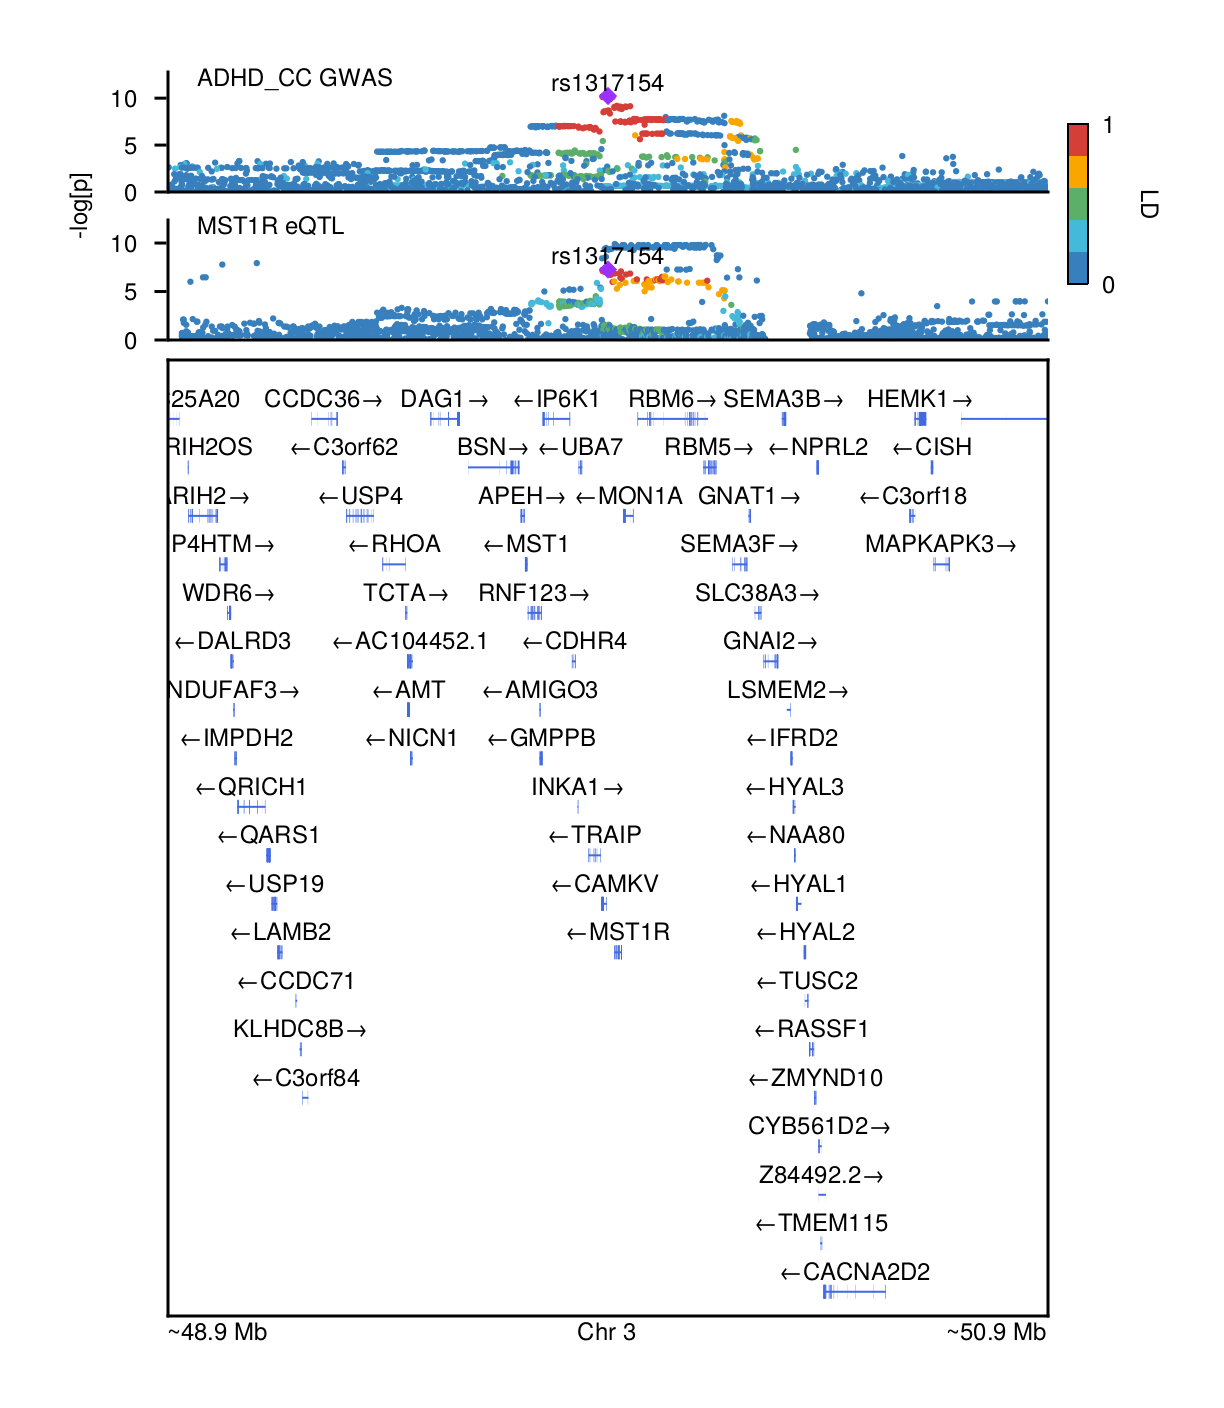

In [17]:
# Plotting locuszoom plots
locuszoomcolormap = [colorant"#377fbd",
                     colorant"#45b9da",
                     colorant"#5baf68",
                     colorant"#faa600",
                     colorant"#d43f38"]
CairoMakie.activate!(type = "png", px_per_unit = 4)
f = Figure(resolution = (306, 792))
axs = [Axis(f[i, 1]) for i in 1:(1 + length(summarystatsdfs))]
for i in 1:n
    if typeof(lddata[i]) == SnpData
        ldfilename = tempname()
        SnpArrays.filter(lddata[i].srcbed, lddata[i].srcbim, lddata[i].srcfam,
                         1:size(lddata[i].snparray, 1),
                         findall(row -> row.chromosome == chr &&
                                 range1 <= row.position <= range2,
                                 eachrow(lddata[i].snp_info));
                         des = ldfilename)
        plotlocus!(axs[i], chr, range1, range2, summarystatsdfs[i];
           ld = (SnpData(ldfilename), snpid))
    else
        plotlocus!(axs[i], chr, range1, range2, summarystatsdfs[i];
           ld = (lddata[i], snpid))
    end
    rowsize!(f.layout, i, 30)
    Label(f[i, 1, Top()], titles[i];
          fontsize = 6, halign = :left, padding = (7.5, 0, -5, 0))
end
rs = GeneticsMakie.plotgenes!(axs[n + 1], chr, range1, range2, gencode; height = 0.1)
rowsize!(f.layout, n + 1, rs)
GeneticsMakie.labelgenome(f[n + 1, 1, Bottom()], chr, range1, range2)
Colorbar(f[1:n, 2], limits = (0, 1), ticks = 0:1, height = 40,
         colormap = cgrad(locuszoomcolormap, 5, categorical = true), label = "LD", 
         ticksize = 0, tickwidth = 0, tickalign = 0, ticklabelsize = 6,
         flip_vertical_label = true, labelsize = 6, width = 5, spinewidth = 0.5)
Label(f[1:n, 0], text = "-log[p]", fontsize = 6, rotation = pi / 2)
rowgap!(f.layout, 5)
colgap!(f.layout, 5)
resize_to_layout!(f)
f

In [18]:
CairoMakie.activate!(type = "png")
outputfilename = "/u/project/gandalm/cindywen/ipsych_gwas/figures/locus20/MST1R.png"
save(outputfilename, f, px_per_unit = 4)

CairoMakie.Screen{IMAGE}


In [19]:
# snpid = "rs2681780"

# # Finding locus
# chr = subset(lddata[end].snp_info,
#                     :snpid => col -> col .== snpid)[1, :chromosome]
# start = subset(lddata[end].snp_info,
#                     :snpid => col -> col .== snpid)[1, :position]
# stop = start
# range1 = start - 1e6
# range2 = stop + 1e6
# n = length(summarystatsdfs)
# titles = ["ADHD_CC GWAS", "MST1R eQTL"]
# println(subset(lddata[end].snp_info, :snpid => col -> col .== snpid))

# # Plotting locuszoom plots
# locuszoomcolormap = [colorant"#377fbd",
#                      colorant"#45b9da",
#                      colorant"#5baf68",
#                      colorant"#faa600",
#                      colorant"#d43f38"]
# CairoMakie.activate!(type = "png", px_per_unit = 4)
# f = Figure(resolution = (306, 792))
# axs = [Axis(f[i, 1]) for i in 1:(1 + length(summarystatsdfs))]
# for i in 1:n
#     if typeof(lddata[i]) == SnpData
#         ldfilename = tempname()
#         SnpArrays.filter(lddata[i].srcbed, lddata[i].srcbim, lddata[i].srcfam,
#                          1:size(lddata[i].snparray, 1),
#                          findall(row -> row.chromosome == chr &&
#                                  range1 <= row.position <= range2,
#                                  eachrow(lddata[i].snp_info));
#                          des = ldfilename)
#         plotlocus!(axs[i], chr, range1, range2, summarystatsdfs[i];
#            ld = (SnpData(ldfilename), snpid))
#     else
#         plotlocus!(axs[i], chr, range1, range2, summarystatsdfs[i];
#            ld = (lddata[i], snpid))
#     end
#     rowsize!(f.layout, i, 30)
#     Label(f[i, 1, Top()], titles[i];
#           textsize = 6, halign = :left, padding = (7.5, 0, -5, 0))
# end
# rs = GeneticsMakie.plotgenes!(axs[n + 1], chr, range1, range2, gencode; height = 0.1)
# rowsize!(f.layout, n + 1, rs)
# GeneticsMakie.labelgenome(f[n + 1, 1, Bottom()], chr, range1, range2)
# Colorbar(f[1:n, 2], limits = (0, 1), ticks = 0:1, height = 40,
#          colormap = cgrad(locuszoomcolormap, 5, categorical = true), label = "LD", 
#          ticksize = 0, tickwidth = 0, tickalign = 0, ticklabelsize = 6,
#          flip_vertical_label = true, labelsize = 6, width = 5, spinewidth = 0.5)
# Label(f[1:n, 0], text = "-log[p]", textsize = 6, rotation = pi / 2)
# rowgap!(f.layout, 5)
# colgap!(f.layout, 5)
# resize_to_layout!(f)
# f

In [20]:
# CairoMakie.activate!(type = "png")
# outputfilename = "/u/project/gandalm/cindywen/ipsych_gwas/figures/locus20/MST1R_rs2681780.png"
# save(outputfilename, f, px_per_unit = 4)

In [21]:
summarystatsdfs = [
    CSV.read("/u/project/gandalm/cindywen/ipsych_gwas/figures/locus20/gwas.txt", DataFrame),
    CSV.read("/u/project/gandalm/cindywen/ipsych_gwas/out/locus20/3:49775855:49823787:clu_40022_NA_all_pairs.txt", DataFrame;
                            header = ["geneid", "snpid", "distance", "ma_samples", "ma_count", "maf", "p",
                                      "beta", "slope_se"])
    ]

lddata = [
    read_LDMatrix("/u/project/gandalm/cindywen/ipsych_gwas/data/index_snps_ld_matrices/IndexSNPsRegions_3_48910084_50910084"),
    SnpData("/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/test")
]
summarystatsdfs[2].Z = summarystatsdfs[2].beta ./ summarystatsdfs[2].slope_se

summarystatsdfs[2] = innerjoin(select(lddata[2].snp_info,
                                    :chromosome, :snpid, :position),
                             summarystatsdfs[2]; on = :snpid)

GeneticsMakie.mungesumstats!(summarystatsdfs)
snpid = "rs2681780"

# Finding locus
chr = subset(lddata[end].snp_info,
                    :snpid => col -> col .== snpid)[1, :chromosome]
start = subset(lddata[end].snp_info,
                    :snpid => col -> col .== snpid)[1, :position]
stop = start
range1 = start - 1e6
range2 = stop + 1e6
n = length(summarystatsdfs)
titles = ["ADHD_CC GWAS", "IP6K1 sQTL"]
println(subset(lddata[end].snp_info, :snpid => col -> col .== snpid))

1×6 DataFrame
 Row │ chromosome  snpid      genetic_distance  position  allele1  allele2 
     │ String      String     Float64           Int64     String   String  
─────┼─────────────────────────────────────────────────────────────────────
   1 │ 3           rs2681780               0.0  49897830  T        C


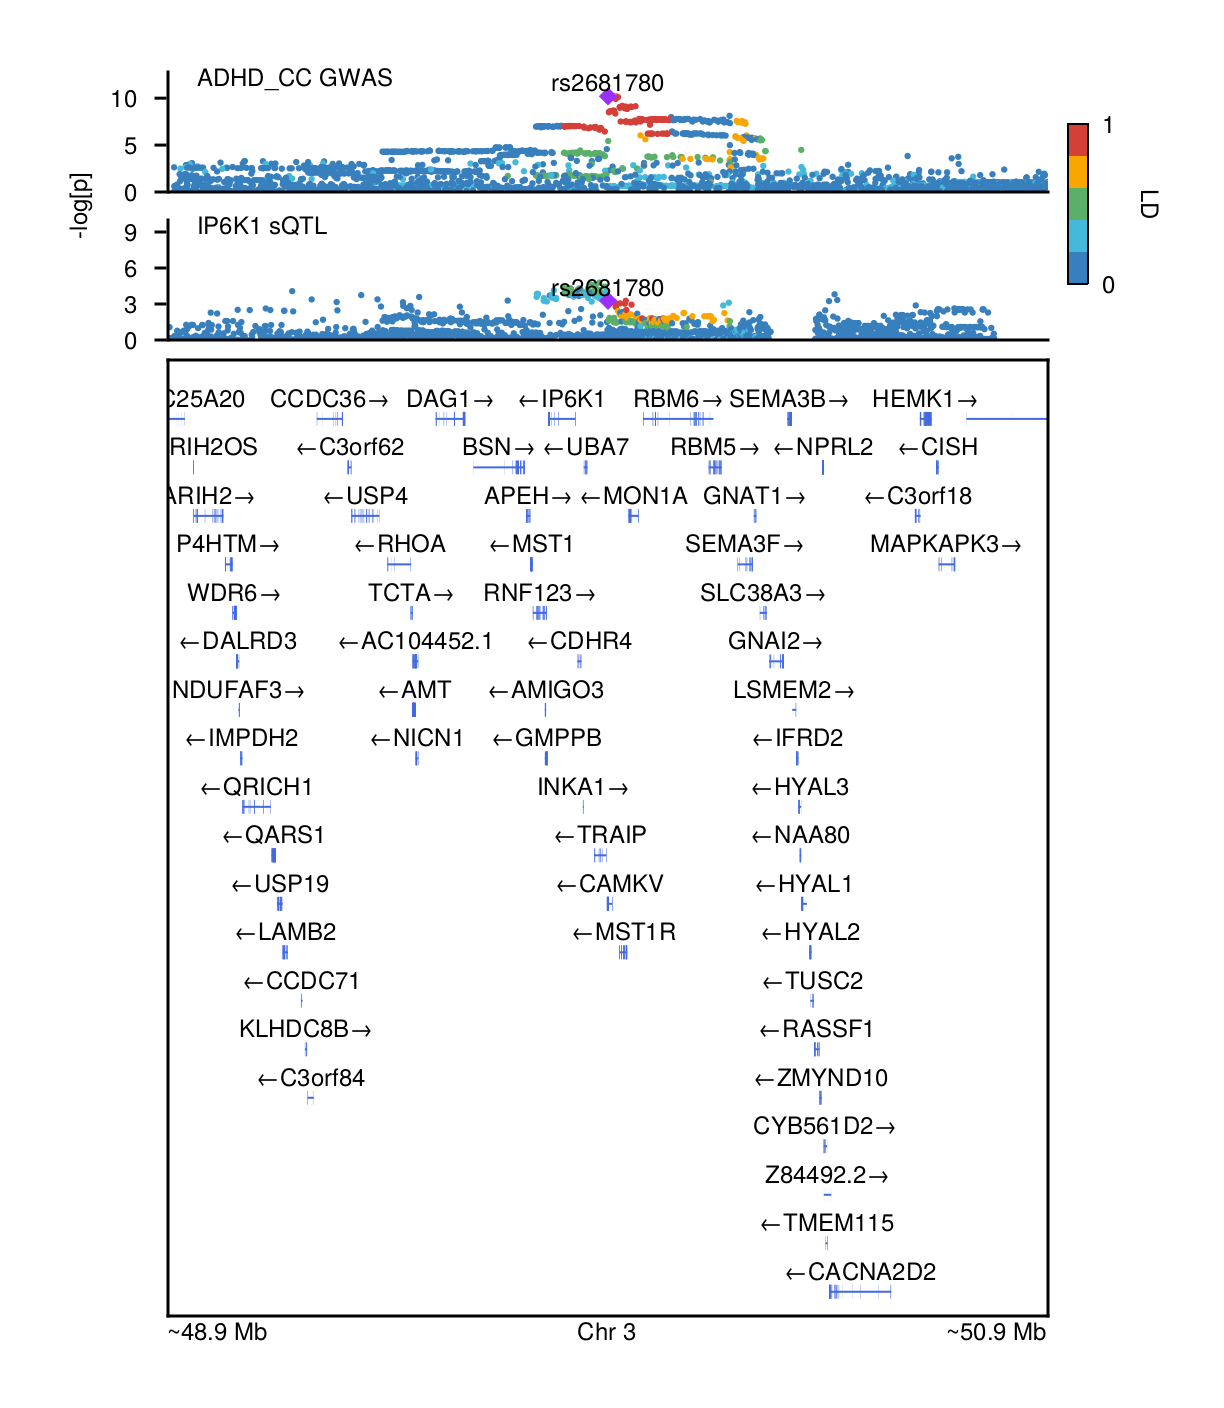

In [22]:
# Plotting locuszoom plots
locuszoomcolormap = [colorant"#377fbd",
                     colorant"#45b9da",
                     colorant"#5baf68",
                     colorant"#faa600",
                     colorant"#d43f38"]
CairoMakie.activate!(type = "png", px_per_unit = 4)
f = Figure(resolution = (306, 792))
axs = [Axis(f[i, 1]) for i in 1:(1 + length(summarystatsdfs))]
for i in 1:n
    if typeof(lddata[i]) == SnpData
        ldfilename = tempname()
        SnpArrays.filter(lddata[i].srcbed, lddata[i].srcbim, lddata[i].srcfam,
                         1:size(lddata[i].snparray, 1),
                         findall(row -> row.chromosome == chr &&
                                 range1 <= row.position <= range2,
                                 eachrow(lddata[i].snp_info));
                         des = ldfilename)
        plotlocus!(axs[i], chr, range1, range2, summarystatsdfs[i];
           ld = (SnpData(ldfilename), snpid))
    else
        plotlocus!(axs[i], chr, range1, range2, summarystatsdfs[i];
           ld = (lddata[i], snpid))
    end
    rowsize!(f.layout, i, 30)
    Label(f[i, 1, Top()], titles[i];
          fontsize = 6, halign = :left, padding = (7.5, 0, -5, 0))
end
rs = GeneticsMakie.plotgenes!(axs[n + 1], chr, range1, range2, gencode; height = 0.1)
rowsize!(f.layout, n + 1, rs)
GeneticsMakie.labelgenome(f[n + 1, 1, Bottom()], chr, range1, range2)
Colorbar(f[1:n, 2], limits = (0, 1), ticks = 0:1, height = 40,
         colormap = cgrad(locuszoomcolormap, 5, categorical = true), label = "LD", 
         ticksize = 0, tickwidth = 0, tickalign = 0, ticklabelsize = 6,
         flip_vertical_label = true, labelsize = 6, width = 5, spinewidth = 0.5)
Label(f[1:n, 0], text = "-log[p]", fontsize = 6, rotation = pi / 2)
rowgap!(f.layout, 5)
colgap!(f.layout, 5)
resize_to_layout!(f)
f

In [23]:
CairoMakie.activate!(type = "png")
outputfilename = "/u/project/gandalm/cindywen/ipsych_gwas/figures/locus20/IP6K1_rs2681780.png"
save(outputfilename, f, px_per_unit = 4)

CairoMakie.Screen{IMAGE}


1×6 DataFrame
 Row │ chromosome  snpid      genetic_distance  position  allele1  allele2 
     │ String      String     Float64           Int64     String   String  
─────┼─────────────────────────────────────────────────────────────────────
   1 │ 3           rs2681780               0.0  49897830  T        C


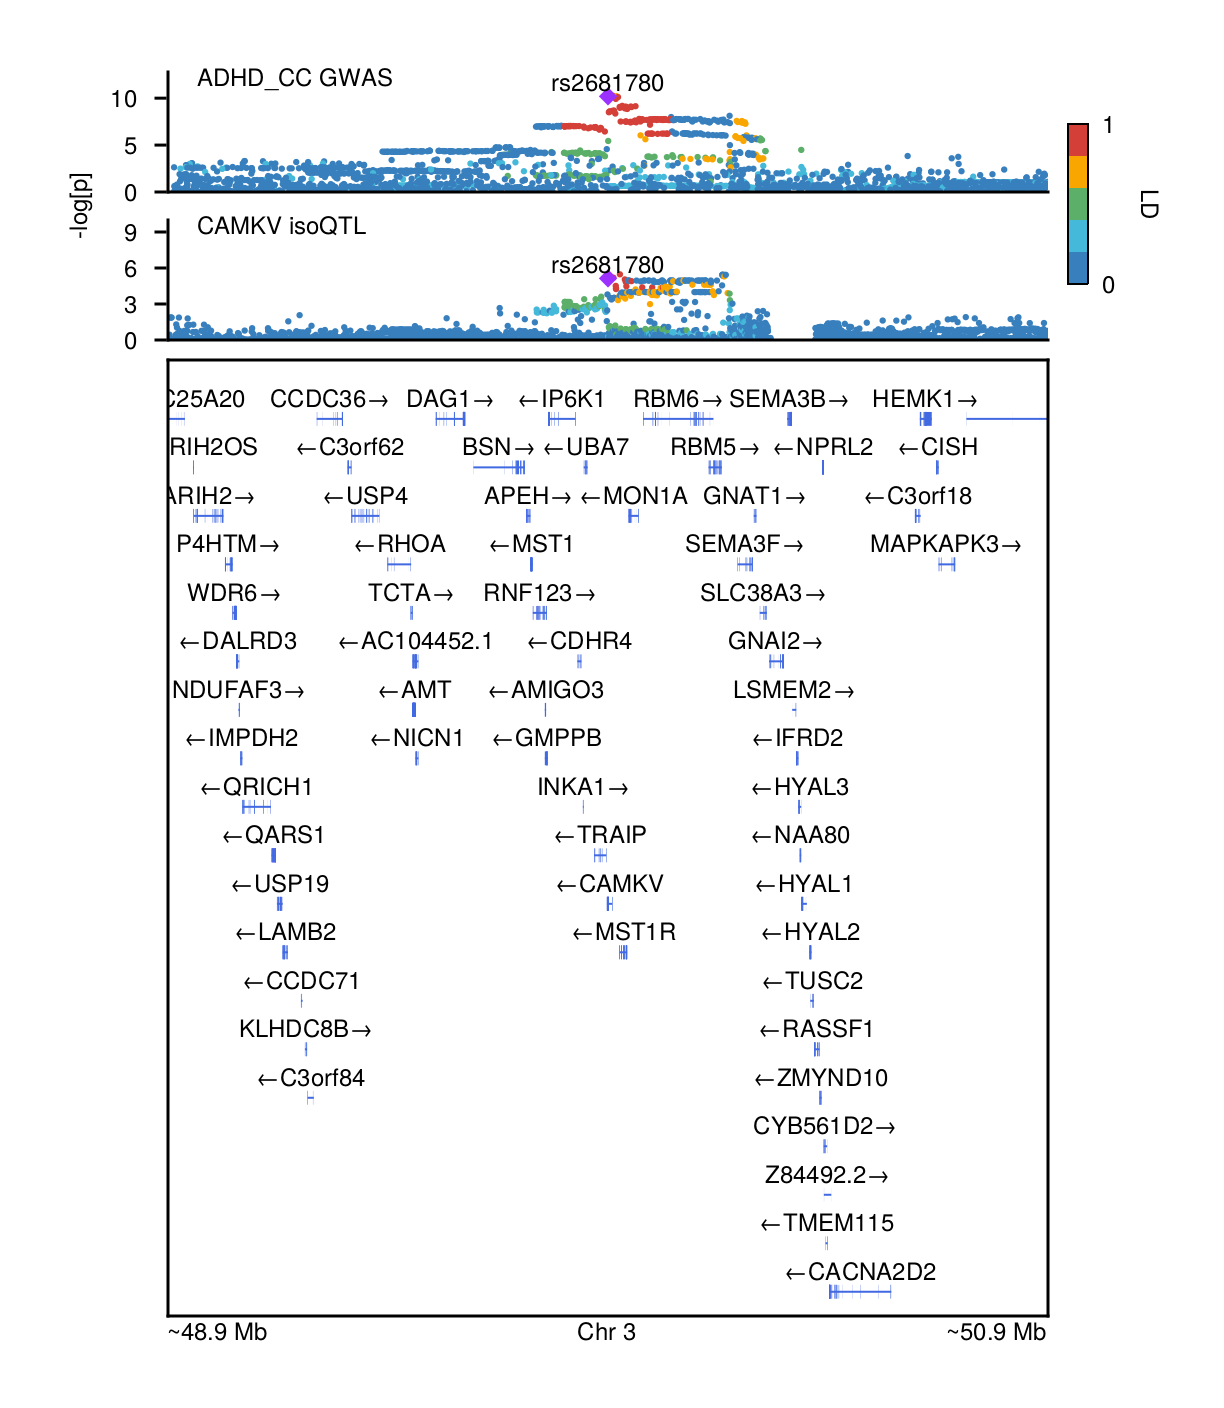

In [24]:
summarystatsdfs = [
    CSV.read("/u/project/gandalm/cindywen/ipsych_gwas/figures/locus20/gwas.txt", DataFrame),
    CSV.read("/u/project/gandalm/cindywen/ipsych_gwas/out/locus20/ENST00000478149.5_2_all_pairs.txt", DataFrame;
                            header = ["geneid", "snpid", "distance", "ma_samples", "ma_count", "maf", "p",
                                      "beta", "slope_se"])
    ]

lddata = [
    read_LDMatrix("/u/project/gandalm/cindywen/ipsych_gwas/data/index_snps_ld_matrices/IndexSNPsRegions_3_48910084_50910084"),
    SnpData("/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/test")
]
summarystatsdfs[2].Z = summarystatsdfs[2].beta ./ summarystatsdfs[2].slope_se

summarystatsdfs[2] = innerjoin(select(lddata[2].snp_info,
                                    :chromosome, :snpid, :position),
                             summarystatsdfs[2]; on = :snpid)

GeneticsMakie.mungesumstats!(summarystatsdfs)
snpid = "rs2681780"

# Finding locus
chr = subset(lddata[end].snp_info,
                    :snpid => col -> col .== snpid)[1, :chromosome]
start = subset(lddata[end].snp_info,
                    :snpid => col -> col .== snpid)[1, :position]
stop = start
range1 = start - 1e6
range2 = stop + 1e6
n = length(summarystatsdfs)
titles = ["ADHD_CC GWAS", "CAMKV isoQTL"]
println(subset(lddata[end].snp_info, :snpid => col -> col .== snpid))

# Plotting locuszoom plots
locuszoomcolormap = [colorant"#377fbd",
                     colorant"#45b9da",
                     colorant"#5baf68",
                     colorant"#faa600",
                     colorant"#d43f38"]
CairoMakie.activate!(type = "png", px_per_unit = 4)
f = Figure(resolution = (306, 792))
axs = [Axis(f[i, 1]) for i in 1:(1 + length(summarystatsdfs))]
for i in 1:n
    if typeof(lddata[i]) == SnpData
        ldfilename = tempname()
        SnpArrays.filter(lddata[i].srcbed, lddata[i].srcbim, lddata[i].srcfam,
                         1:size(lddata[i].snparray, 1),
                         findall(row -> row.chromosome == chr &&
                                 range1 <= row.position <= range2,
                                 eachrow(lddata[i].snp_info));
                         des = ldfilename)
        plotlocus!(axs[i], chr, range1, range2, summarystatsdfs[i];
           ld = (SnpData(ldfilename), snpid))
    else
        plotlocus!(axs[i], chr, range1, range2, summarystatsdfs[i];
           ld = (lddata[i], snpid))
    end
    rowsize!(f.layout, i, 30)
    Label(f[i, 1, Top()], titles[i];
          fontsize = 6, halign = :left, padding = (7.5, 0, -5, 0))
end
rs = GeneticsMakie.plotgenes!(axs[n + 1], chr, range1, range2, gencode; height = 0.1)
rowsize!(f.layout, n + 1, rs)
GeneticsMakie.labelgenome(f[n + 1, 1, Bottom()], chr, range1, range2)
Colorbar(f[1:n, 2], limits = (0, 1), ticks = 0:1, height = 40,
         colormap = cgrad(locuszoomcolormap, 5, categorical = true), label = "LD", 
         ticksize = 0, tickwidth = 0, tickalign = 0, ticklabelsize = 6,
         flip_vertical_label = true, labelsize = 6, width = 5, spinewidth = 0.5)
Label(f[1:n, 0], text = "-log[p]", fontsize = 6, rotation = pi / 2)
rowgap!(f.layout, 5)
colgap!(f.layout, 5)
resize_to_layout!(f)
f

In [25]:
CairoMakie.activate!(type = "png")
outputfilename = "/u/project/gandalm/cindywen/ipsych_gwas/figures/locus20/CAMKV_rs2681780.png"
save(outputfilename, f, px_per_unit = 4)

CairoMakie.Screen{IMAGE}


**locus 15, in R, calculate Zscores for tri QTL sum stats**

1×6 DataFrame
 Row │ chromosome  snpid       genetic_distance  position   allele1  allele2 
     │ String      String      Float64           Int64      String   String  
─────┼───────────────────────────────────────────────────────────────────────
   1 │ 2           rs62202043               0.0  215728285  T        C


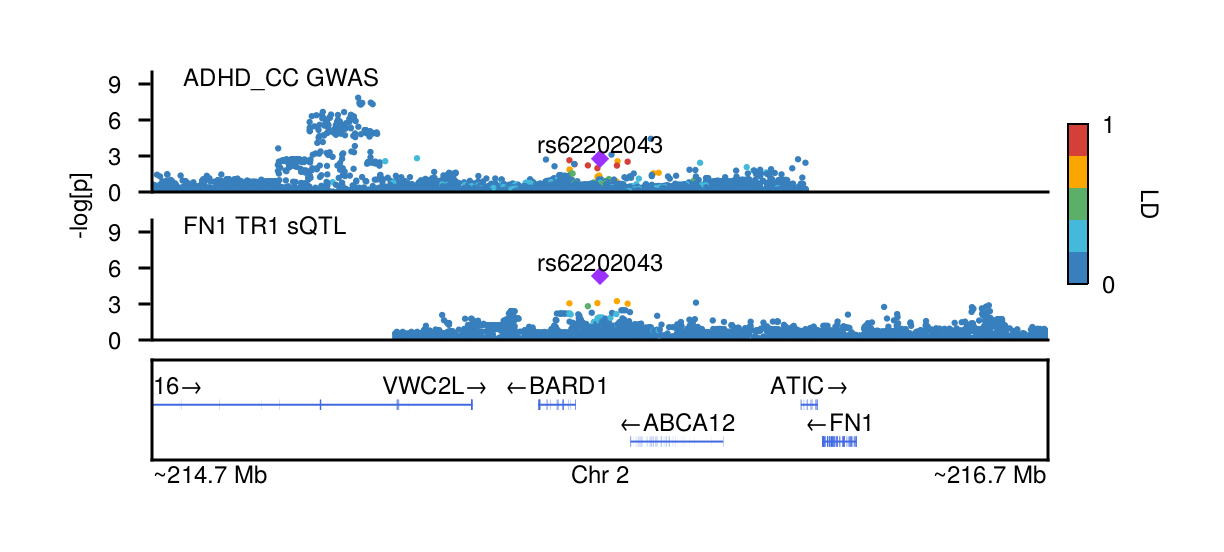

In [26]:
summarystatsdfs = [
    CSV.read("/u/project/gandalm/cindywen/ipsych_gwas/figures/locus15/gwas.txt", DataFrame),
    CSV.read("/u/project/gandalm/cindywen/ipsych_gwas/figures/locus15/2:216271227:216271850:clu_6411_NA_all_pairs_tri1_15hcp_zscore.txt", DataFrame;
                            header = ["geneid", "snpid", "distance", "p", "beta", "Z"])
    ]

lddata = [
    read_LDMatrix("/u/project/gandalm/cindywen/ipsych_gwas/data/index_snps_ld_matrices/IndexSNPsRegions_2_214188444_216188444"),
    SnpData("/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/eur/filtered.hg19.sorted.removeRel")
]
# summarystatsdfs[2].Z = sign(summarystatsdfs[2].beta) .* abs(qnorm(summarystatsdfs[2].p/2))

summarystatsdfs[2] = innerjoin(select(lddata[2].snp_info,
                                    :chromosome, :snpid, :position),
                             summarystatsdfs[2]; on = :snpid)

GeneticsMakie.mungesumstats!(summarystatsdfs)
snpid = "rs62202043"

# Finding locus
chr = subset(lddata[end].snp_info,
                    :snpid => col -> col .== snpid)[1, :chromosome]
start = subset(lddata[end].snp_info,
                    :snpid => col -> col .== snpid)[1, :position]
stop = start
range1 = start - 1e6
range2 = stop + 1e6
n = length(summarystatsdfs)
titles = ["ADHD_CC GWAS", "FN1 TR1 sQTL"]
println(subset(lddata[end].snp_info, :snpid => col -> col .== snpid))

# Plotting locuszoom plots
locuszoomcolormap = [colorant"#377fbd",
                     colorant"#45b9da",
                     colorant"#5baf68",
                     colorant"#faa600",
                     colorant"#d43f38"]
CairoMakie.activate!(type = "png", px_per_unit = 4)
f = Figure(resolution = (306, 792))
axs = [Axis(f[i, 1]) for i in 1:(1 + length(summarystatsdfs))]
for i in 1:n
    if typeof(lddata[i]) == SnpData
        ldfilename = tempname()
        SnpArrays.filter(lddata[i].srcbed, lddata[i].srcbim, lddata[i].srcfam,
                         1:size(lddata[i].snparray, 1),
                         findall(row -> row.chromosome == chr &&
                                 range1 <= row.position <= range2,
                                 eachrow(lddata[i].snp_info));
                         des = ldfilename)
        plotlocus!(axs[i], chr, range1, range2, summarystatsdfs[i];
           ld = (SnpData(ldfilename), snpid))
    else
        plotlocus!(axs[i], chr, range1, range2, summarystatsdfs[i];
           ld = (lddata[i], snpid))
    end
    rowsize!(f.layout, i, 30)
    Label(f[i, 1, Top()], titles[i];
          fontsize = 6, halign = :left, padding = (7.5, 0, -5, 0))
end
rs = GeneticsMakie.plotgenes!(axs[n + 1], chr, range1, range2, gencode; height = 0.1)
rowsize!(f.layout, n + 1, rs)
GeneticsMakie.labelgenome(f[n + 1, 1, Bottom()], chr, range1, range2)
Colorbar(f[1:n, 2], limits = (0, 1), ticks = 0:1, height = 40,
         colormap = cgrad(locuszoomcolormap, 5, categorical = true), label = "LD", 
         ticksize = 0, tickwidth = 0, tickalign = 0, ticklabelsize = 6,
         flip_vertical_label = true, labelsize = 6, width = 5, spinewidth = 0.5)
Label(f[1:n, 0], text = "-log[p]", fontsize = 6, rotation = pi / 2)
rowgap!(f.layout, 5)
colgap!(f.layout, 5)
resize_to_layout!(f)
f

In [27]:
CairoMakie.activate!(type = "png")
outputfilename = "/u/project/gandalm/cindywen/ipsych_gwas/figures/locus15/FN1.png"
save(outputfilename, f, px_per_unit = 4)

CairoMakie.Screen{IMAGE}


**locus56**

1×6 DataFrame
 Row │ chromosome  snpid       genetic_distance  position  allele1  allele2 
     │ String      String      Float64           Int64     String   String  
─────┼──────────────────────────────────────────────────────────────────────
   1 │ 18          rs58461566               0.0  21895042  C        T


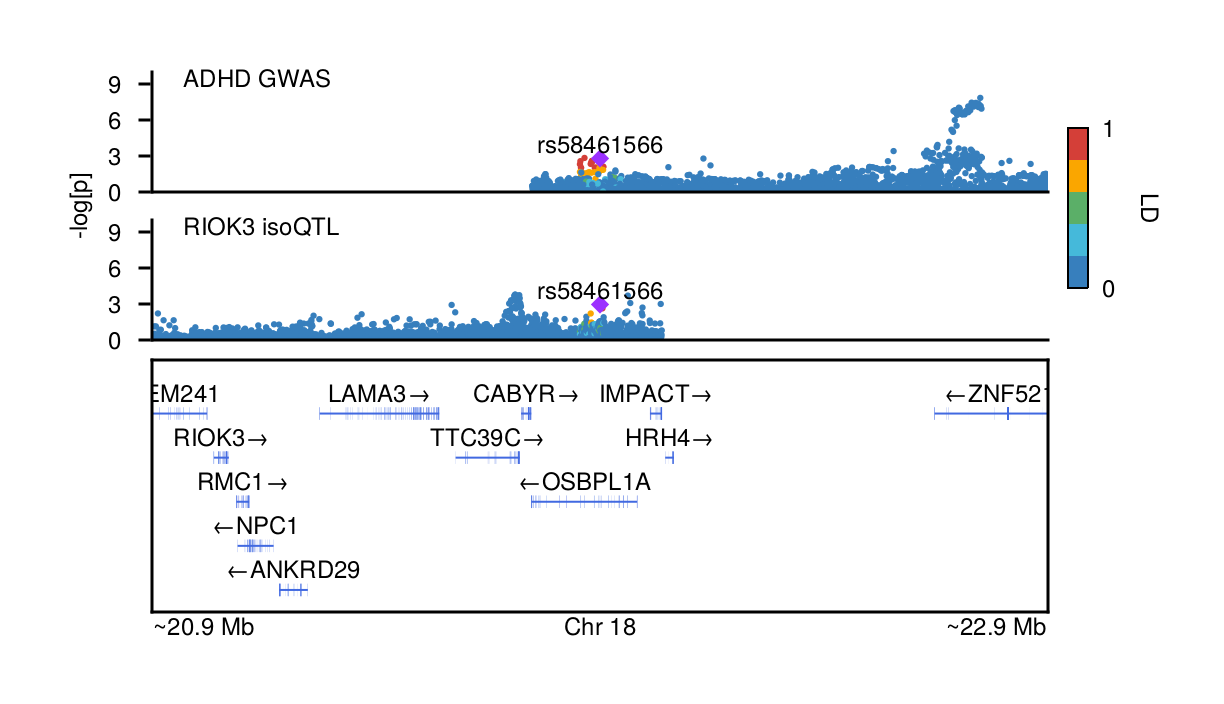

In [28]:
summarystatsdfs = [
    CSV.read("/u/project/gandalm/cindywen/ipsych_gwas/figures/locus56/gwas.txt", DataFrame),
    CSV.read("/u/project/gandalm/cindywen/ipsych_gwas/out/locus56/ENST00000577501.5_1_all_pairs.txt", DataFrame;
                            header = ["geneid", "snpid", "distance", "ma_samples", "ma_count", "maf", "p",
                                      "beta", "slope_se"])
    ]

lddata = [
    read_LDMatrix("/u/project/gandalm/cindywen/ipsych_gwas/data/index_snps_ld_matrices/IndexSNPsRegions_18_21743899_23743899"),
    SnpData("/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/test")
]
summarystatsdfs[2].Z = summarystatsdfs[2].beta ./ summarystatsdfs[2].slope_se

summarystatsdfs[2] = innerjoin(select(lddata[2].snp_info,
                                    :chromosome, :snpid, :position),
                             summarystatsdfs[2]; on = :snpid)

GeneticsMakie.mungesumstats!(summarystatsdfs)
snpid = "rs58461566"

# Finding locus
chr = subset(lddata[end].snp_info,
                    :snpid => col -> col .== snpid)[1, :chromosome]
start = subset(lddata[end].snp_info,
                    :snpid => col -> col .== snpid)[1, :position]
stop = start
range1 = start - 1e6
range2 = stop + 1e6
n = length(summarystatsdfs)
titles = ["ADHD GWAS", "RIOK3 isoQTL"]
println(subset(lddata[end].snp_info, :snpid => col -> col .== snpid))

# Plotting locuszoom plots
locuszoomcolormap = [colorant"#377fbd",
                     colorant"#45b9da",
                     colorant"#5baf68",
                     colorant"#faa600",
                     colorant"#d43f38"]
CairoMakie.activate!(type = "png", px_per_unit = 4)
f = Figure(resolution = (306, 792))
axs = [Axis(f[i, 1]) for i in 1:(1 + length(summarystatsdfs))]
for i in 1:n
    if typeof(lddata[i]) == SnpData
        ldfilename = tempname()
        SnpArrays.filter(lddata[i].srcbed, lddata[i].srcbim, lddata[i].srcfam,
                         1:size(lddata[i].snparray, 1),
                         findall(row -> row.chromosome == chr &&
                                 range1 <= row.position <= range2,
                                 eachrow(lddata[i].snp_info));
                         des = ldfilename)
        plotlocus!(axs[i], chr, range1, range2, summarystatsdfs[i];
           ld = (SnpData(ldfilename), snpid))
    else
        plotlocus!(axs[i], chr, range1, range2, summarystatsdfs[i];
           ld = (lddata[i], snpid))
    end
    rowsize!(f.layout, i, 30)
    Label(f[i, 1, Top()], titles[i];
          fontsize = 6, halign = :left, padding = (7.5, 0, -5, 0))
end
rs = GeneticsMakie.plotgenes!(axs[n + 1], chr, range1, range2, gencode; height = 0.1)
rowsize!(f.layout, n + 1, rs)
GeneticsMakie.labelgenome(f[n + 1, 1, Bottom()], chr, range1, range2)
Colorbar(f[1:n, 2], limits = (0, 1), ticks = 0:1, height = 40,
         colormap = cgrad(locuszoomcolormap, 5, categorical = true), label = "LD", 
         ticksize = 0, tickwidth = 0, tickalign = 0, ticklabelsize = 6,
         flip_vertical_label = true, labelsize = 6, width = 5, spinewidth = 0.5)
Label(f[1:n, 0], text = "-log[p]", fontsize = 6, rotation = pi / 2)
rowgap!(f.layout, 5)
colgap!(f.layout, 5)
resize_to_layout!(f)
f

In [29]:
CairoMakie.activate!(type = "png")
outputfilename = "/u/project/gandalm/cindywen/ipsych_gwas/figures/locus56/RIOK3.png"
save(outputfilename, f, px_per_unit = 4)

CairoMakie.Screen{IMAGE}


**locus4**

1×6 DataFrame
 Row │ chromosome  snpid       genetic_distance  position  allele1  allele2 
     │ String      String      Float64           Int64     String   String  
─────┼──────────────────────────────────────────────────────────────────────
   1 │ 1           rs79543415               0.0  44813464  C        T


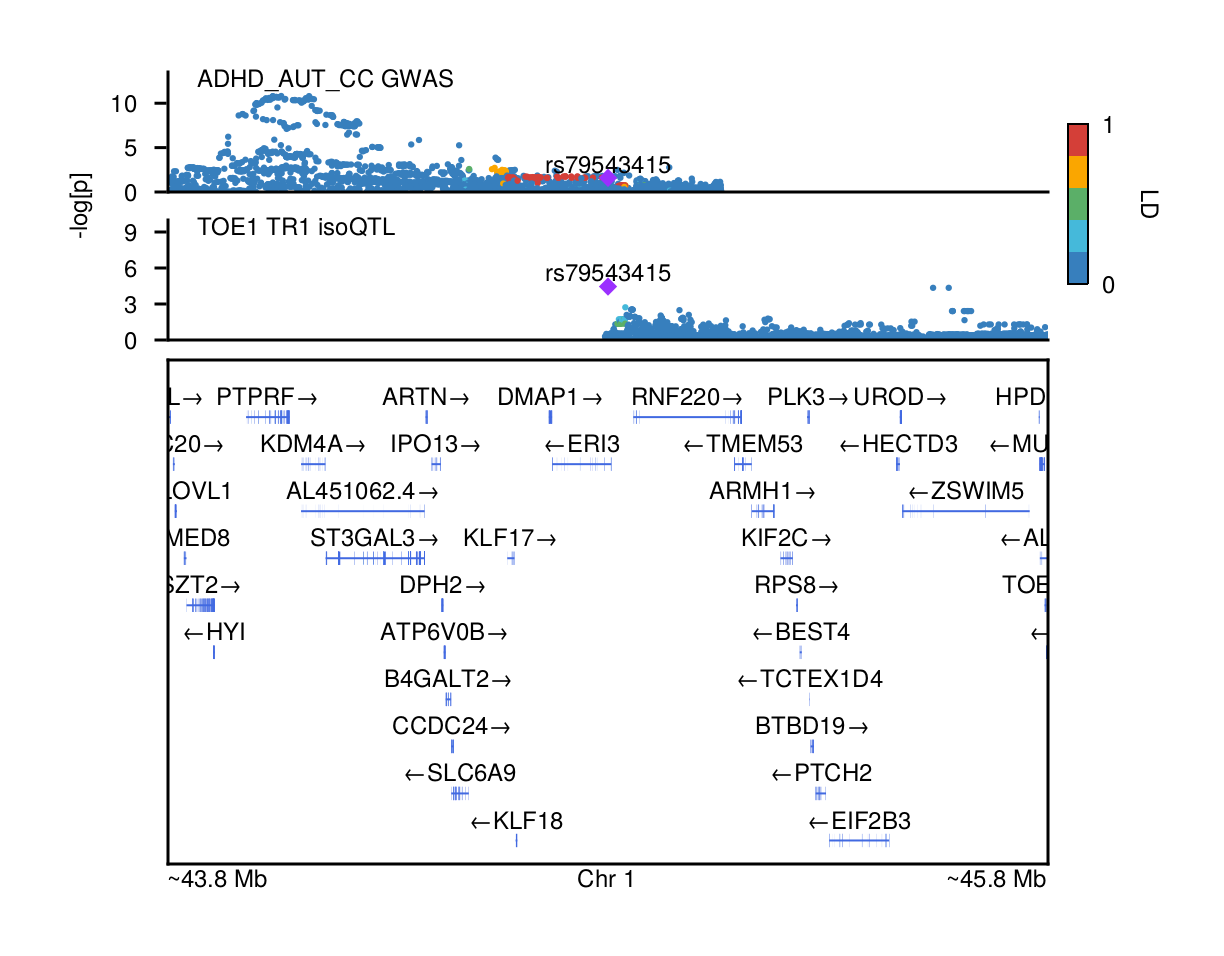

In [30]:
summarystatsdfs = [
    CSV.read("/u/project/gandalm/cindywen/ipsych_gwas/figures/locus4/gwas.txt", DataFrame),
    CSV.read("/u/project/gandalm/cindywen/ipsych_gwas/figures/locus4/ENST00000477731.5_1_all_pairs_tri1_35hcp_zscore.txt", DataFrame;
                            header = ["geneid", "snpid", "distance", "p", "beta", "Z"])
    ]

lddata = [
    read_LDMatrix("/u/project/gandalm/cindywen/ipsych_gwas/data/index_snps_ld_matrices/IndexSNPsRegions_1_43070691_45070691"),
    SnpData("/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/eur/filtered.hg19.sorted.removeRel")
]
# summarystatsdfs[2].Z = sign(summarystatsdfs[2].beta) .* abs(qnorm(summarystatsdfs[2].p/2))

summarystatsdfs[2] = innerjoin(select(lddata[2].snp_info,
                                    :chromosome, :snpid, :position),
                             summarystatsdfs[2]; on = :snpid)

GeneticsMakie.mungesumstats!(summarystatsdfs)
snpid = "rs79543415"

# Finding locus
chr = subset(lddata[end].snp_info,
                    :snpid => col -> col .== snpid)[1, :chromosome]
start = subset(lddata[end].snp_info,
                    :snpid => col -> col .== snpid)[1, :position]
stop = start
range1 = start - 1e6
range2 = stop + 1e6
n = length(summarystatsdfs)
titles = ["ADHD_AUT_CC GWAS", "TOE1 TR1 isoQTL"]
println(subset(lddata[end].snp_info, :snpid => col -> col .== snpid))

# Plotting locuszoom plots
locuszoomcolormap = [colorant"#377fbd",
                     colorant"#45b9da",
                     colorant"#5baf68",
                     colorant"#faa600",
                     colorant"#d43f38"]
CairoMakie.activate!(type = "png", px_per_unit = 4)
f = Figure(resolution = (306, 792))
axs = [Axis(f[i, 1]) for i in 1:(1 + length(summarystatsdfs))]
for i in 1:n
    if typeof(lddata[i]) == SnpData
        ldfilename = tempname()
        SnpArrays.filter(lddata[i].srcbed, lddata[i].srcbim, lddata[i].srcfam,
                         1:size(lddata[i].snparray, 1),
                         findall(row -> row.chromosome == chr &&
                                 range1 <= row.position <= range2,
                                 eachrow(lddata[i].snp_info));
                         des = ldfilename)
        plotlocus!(axs[i], chr, range1, range2, summarystatsdfs[i];
           ld = (SnpData(ldfilename), snpid))
    else
        plotlocus!(axs[i], chr, range1, range2, summarystatsdfs[i];
           ld = (lddata[i], snpid))
    end
    rowsize!(f.layout, i, 30)
    Label(f[i, 1, Top()], titles[i];
          fontsize = 6, halign = :left, padding = (7.5, 0, -5, 0))
end
rs = GeneticsMakie.plotgenes!(axs[n + 1], chr, range1, range2, gencode; height = 0.1)
rowsize!(f.layout, n + 1, rs)
GeneticsMakie.labelgenome(f[n + 1, 1, Bottom()], chr, range1, range2)
Colorbar(f[1:n, 2], limits = (0, 1), ticks = 0:1, height = 40,
         colormap = cgrad(locuszoomcolormap, 5, categorical = true), label = "LD", 
         ticksize = 0, tickwidth = 0, tickalign = 0, ticklabelsize = 6,
         flip_vertical_label = true, labelsize = 6, width = 5, spinewidth = 0.5)
Label(f[1:n, 0], text = "-log[p]", fontsize = 6, rotation = pi / 2)
rowgap!(f.layout, 5)
colgap!(f.layout, 5)
resize_to_layout!(f)
f

In [31]:
CairoMakie.activate!(type = "png")
outputfilename = "/u/project/gandalm/cindywen/ipsych_gwas/figures/locus4/TOE1.png"
save(outputfilename, f, px_per_unit = 4)

CairoMakie.Screen{IMAGE}


**locus41**

In [38]:
summarystatsdfs = [
    CSV.read("/u/project/gandalm/cindywen/ipsych_gwas/figures/locus41/gwas.txt", DataFrame),
    CSV.read("/u/project/gandalm/cindywen/ipsych_gwas/out/locus41/ENSG00000187391_all_pairs.txt", DataFrame;
                            header = ["geneid", "snpid", "distance", "ma_samples", "ma_count", "maf", "p",
                                      "beta", "slope_se"]),
    CSV.read("/u/project/gandalm/cindywen/ipsych_gwas/out/locus41/ENST00000636717.1_5_all_pairs.txt", DataFrame;
                            header = ["geneid", "snpid", "distance", "ma_samples", "ma_count", "maf", "p",
                                      "beta", "slope_se"]),
    ]

lddata = [
    read_LDMatrix("/u/project/gandalm/cindywen/ipsych_gwas/data/index_snps_ld_matrices/IndexSNPsRegions_7_77217826_79217826"),
    SnpData("/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/test"),
    SnpData("/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/test")
]
summarystatsdfs[2].Z = summarystatsdfs[2].beta ./ summarystatsdfs[2].slope_se
summarystatsdfs[3].Z = summarystatsdfs[3].beta ./ summarystatsdfs[3].slope_se

summarystatsdfs[2] = innerjoin(select(lddata[2].snp_info,
                                    :chromosome, :snpid, :position),
                             summarystatsdfs[2]; on = :snpid)
summarystatsdfs[3] = innerjoin(select(lddata[3].snp_info,
                                    :chromosome, :snpid, :position),
                             summarystatsdfs[3]; on = :snpid)

GeneticsMakie.mungesumstats!(summarystatsdfs)
snpid = "rs34477521"

"rs34477521"

1×6 DataFrame
 Row │ chromosome  snpid       genetic_distance  position  allele1  allele2 
     │ String      String      Float64           Int64     String   String  
─────┼──────────────────────────────────────────────────────────────────────
   1 │ 7           rs34477521               0.0  78192639  A        G


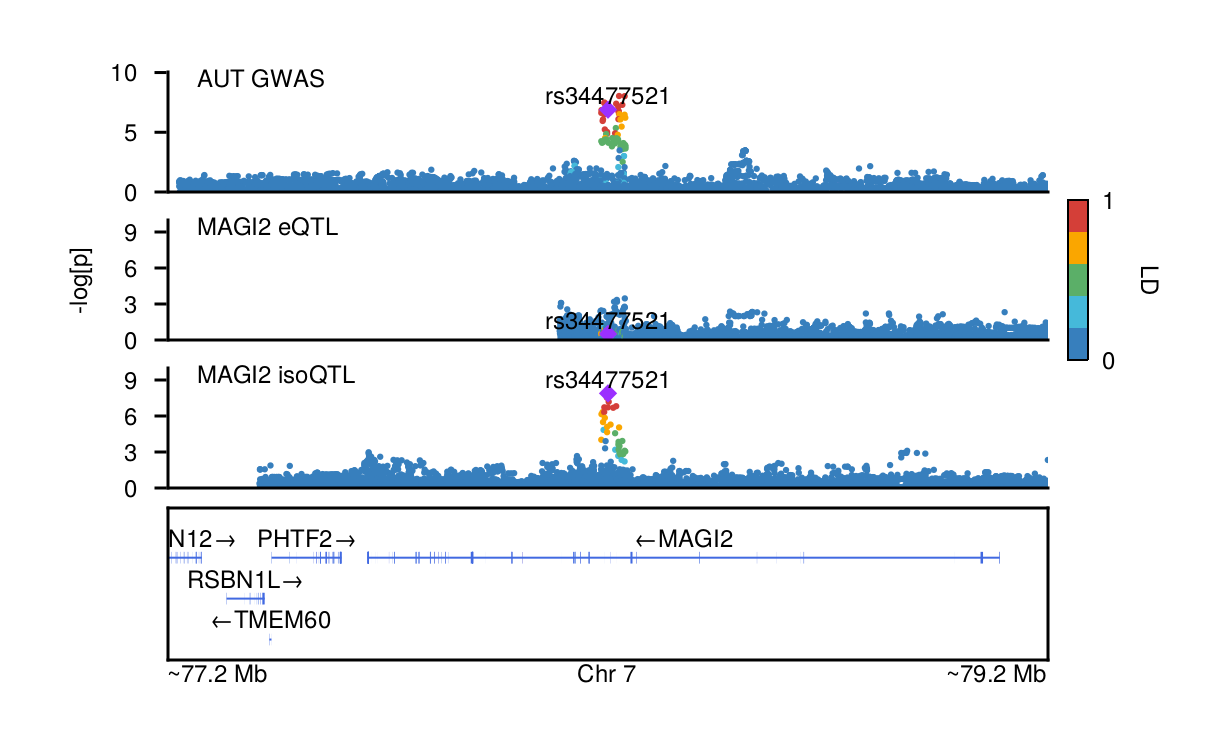

In [40]:
# Finding locus
chr = subset(lddata[end].snp_info,
                    :snpid => col -> col .== snpid)[1, :chromosome]
start = subset(lddata[end].snp_info,
                    :snpid => col -> col .== snpid)[1, :position]
stop = start
range1 = start - 1e6
range2 = stop + 1e6
n = length(summarystatsdfs)
titles = ["AUT GWAS", "MAGI2 eQTL", "MAGI2 isoQTL"]
println(subset(lddata[end].snp_info, :snpid => col -> col .== snpid))

# Plotting locuszoom plots
locuszoomcolormap = [colorant"#377fbd",
                     colorant"#45b9da",
                     colorant"#5baf68",
                     colorant"#faa600",
                     colorant"#d43f38"]
CairoMakie.activate!(type = "png", px_per_unit = 4)
f = Figure(resolution = (306, 792))
axs = [Axis(f[i, 1]) for i in 1:(1 + length(summarystatsdfs))]
for i in 1:n
    if typeof(lddata[i]) == SnpData
        ldfilename = tempname()
        SnpArrays.filter(lddata[i].srcbed, lddata[i].srcbim, lddata[i].srcfam,
                         1:size(lddata[i].snparray, 1),
                         findall(row -> row.chromosome == chr &&
                                 range1 <= row.position <= range2,
                                 eachrow(lddata[i].snp_info));
                         des = ldfilename)
        plotlocus!(axs[i], chr, range1, range2, summarystatsdfs[i];
           ld = (SnpData(ldfilename), snpid))
    else
        plotlocus!(axs[i], chr, range1, range2, summarystatsdfs[i];
           ld = (lddata[i], snpid))
    end
    rowsize!(f.layout, i, 30)
    Label(f[i, 1, Top()], titles[i];
          fontsize = 6, halign = :left, padding = (7.5, 0, -5, 0))
end
rs = GeneticsMakie.plotgenes!(axs[n + 1], chr, range1, range2, gencode; height = 0.1)
rowsize!(f.layout, n + 1, rs)
GeneticsMakie.labelgenome(f[n + 1, 1, Bottom()], chr, range1, range2)
Colorbar(f[1:n, 2], limits = (0, 1), ticks = 0:1, height = 40,
         colormap = cgrad(locuszoomcolormap, 5, categorical = true), label = "LD", 
         ticksize = 0, tickwidth = 0, tickalign = 0, ticklabelsize = 6,
         flip_vertical_label = true, labelsize = 6, width = 5, spinewidth = 0.5)
Label(f[1:n, 0], text = "-log[p]", fontsize = 6, rotation = pi / 2)
rowgap!(f.layout, 5)
colgap!(f.layout, 5)
resize_to_layout!(f)
f

In [41]:
CairoMakie.activate!(type = "png")
outputfilename = "/u/project/gandalm/cindywen/ipsych_gwas/figures/locus41/MAGI2.png"
save(outputfilename, f, px_per_unit = 4)

CairoMakie.Screen{IMAGE}


In [42]:
summarystatsdfs = [
    CSV.read("/u/project/gandalm/cindywen/ipsych_gwas/figures/locus41/gwas.txt", DataFrame),
    CSV.read("/u/project/gandalm/cindywen/ipsych_gwas/out/locus41/7:78150962:78183884:clu_102765_NA_all_pairs.txt", DataFrame;
                            header = ["geneid", "snpid", "distance", "ma_samples", "ma_count", "maf", "p",
                                      "beta", "slope_se"]),
    CSV.read("/u/project/gandalm/cindywen/ipsych_gwas/figures/locus41/7:78150962:78183884:clu_102765_NA_all_pairs_tri1_15hcp_zscore.txt", DataFrame;
                            header = ["geneid", "snpid", "distance", "p", "beta", "Z"]),
    CSV.read("/u/project/gandalm/cindywen/ipsych_gwas/figures/locus41/7:78150962:78183884:clu_102765_NA_all_pairs_tri2_10hcp_zscore.txt", DataFrame;
                            header = ["geneid", "snpid", "distance", "p", "beta", "Z"])
    ]

lddata = [
    read_LDMatrix("/u/project/gandalm/cindywen/ipsych_gwas/data/index_snps_ld_matrices/IndexSNPsRegions_7_77217826_79217826"),
    SnpData("/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/test"),
    SnpData("/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/eur/filtered.hg19.sorted.removeRel"),
    SnpData("/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/eur/filtered.hg19.sorted.removeRel")
]
summarystatsdfs[2].Z = summarystatsdfs[2].beta ./ summarystatsdfs[2].slope_se

summarystatsdfs[2] = innerjoin(select(lddata[2].snp_info,
                                    :chromosome, :snpid, :position),
                             summarystatsdfs[2]; on = :snpid)
summarystatsdfs[3] = innerjoin(select(lddata[3].snp_info,
                                    :chromosome, :snpid, :position),
                             summarystatsdfs[3]; on = :snpid)
summarystatsdfs[4] = innerjoin(select(lddata[4].snp_info,
                                    :chromosome, :snpid, :position),
                             summarystatsdfs[4]; on = :snpid)

GeneticsMakie.mungesumstats!(summarystatsdfs)
snpid = "rs17438461"

"rs17438461"

1×6 DataFrame
 Row │ chromosome  snpid       genetic_distance  position  allele1  allele2 
     │ String      String      Float64           Int64     String   String  
─────┼──────────────────────────────────────────────────────────────────────
   1 │ 7           rs17438461               0.0  78192343  G        A


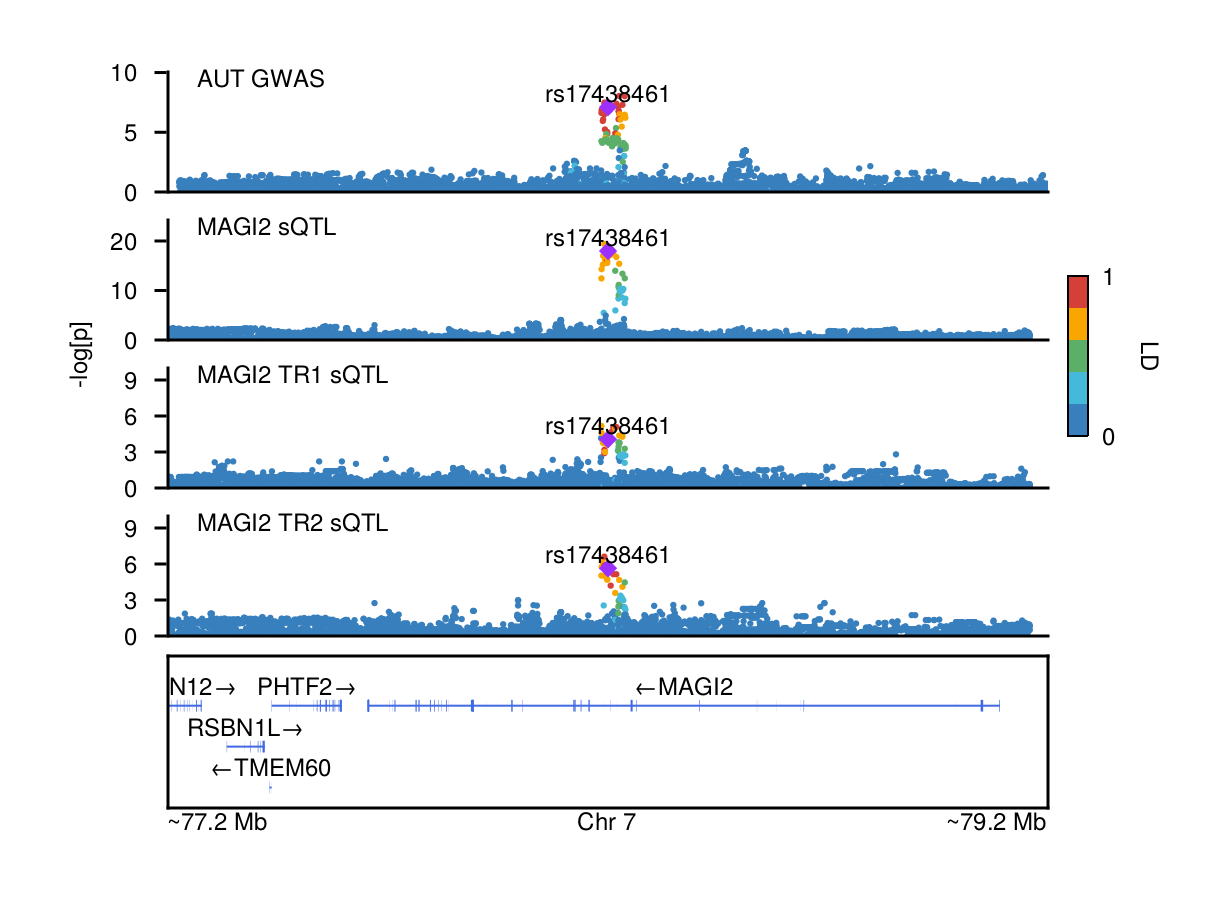

In [43]:
# Finding locus
chr = subset(lddata[end].snp_info,
                    :snpid => col -> col .== snpid)[1, :chromosome]
start = subset(lddata[end].snp_info,
                    :snpid => col -> col .== snpid)[1, :position]
stop = start
range1 = start - 1e6
range2 = stop + 1e6
n = length(summarystatsdfs)
titles = ["AUT GWAS", "MAGI2 sQTL", "MAGI2 TR1 sQTL", "MAGI2 TR2 sQTL"]
println(subset(lddata[end].snp_info, :snpid => col -> col .== snpid))

# Plotting locuszoom plots
locuszoomcolormap = [colorant"#377fbd",
                     colorant"#45b9da",
                     colorant"#5baf68",
                     colorant"#faa600",
                     colorant"#d43f38"]
CairoMakie.activate!(type = "png", px_per_unit = 4)
f = Figure(resolution = (306, 792))
axs = [Axis(f[i, 1]) for i in 1:(1 + length(summarystatsdfs))]
for i in 1:n
    if typeof(lddata[i]) == SnpData
        ldfilename = tempname()
        SnpArrays.filter(lddata[i].srcbed, lddata[i].srcbim, lddata[i].srcfam,
                         1:size(lddata[i].snparray, 1),
                         findall(row -> row.chromosome == chr &&
                                 range1 <= row.position <= range2,
                                 eachrow(lddata[i].snp_info));
                         des = ldfilename)
        plotlocus!(axs[i], chr, range1, range2, summarystatsdfs[i];
           ld = (SnpData(ldfilename), snpid))
    else
        plotlocus!(axs[i], chr, range1, range2, summarystatsdfs[i];
           ld = (lddata[i], snpid))
    end
    rowsize!(f.layout, i, 30)
    Label(f[i, 1, Top()], titles[i];
          fontsize = 6, halign = :left, padding = (7.5, 0, -5, 0))
end
rs = GeneticsMakie.plotgenes!(axs[n + 1], chr, range1, range2, gencode; height = 0.1)
rowsize!(f.layout, n + 1, rs)
GeneticsMakie.labelgenome(f[n + 1, 1, Bottom()], chr, range1, range2)
Colorbar(f[1:n, 2], limits = (0, 1), ticks = 0:1, height = 40,
         colormap = cgrad(locuszoomcolormap, 5, categorical = true), label = "LD", 
         ticksize = 0, tickwidth = 0, tickalign = 0, ticklabelsize = 6,
         flip_vertical_label = true, labelsize = 6, width = 5, spinewidth = 0.5)
Label(f[1:n, 0], text = "-log[p]", fontsize = 6, rotation = pi / 2)
rowgap!(f.layout, 5)
colgap!(f.layout, 5)
resize_to_layout!(f)
f

**locus25**

1×6 DataFrame
 Row │ chromosome  snpid       genetic_distance  position   allele1  allele2 
     │ String      String      Float64           Int64      String   String  
─────┼───────────────────────────────────────────────────────────────────────
   1 │ 4           rs56373539               0.0  134894442  G        A


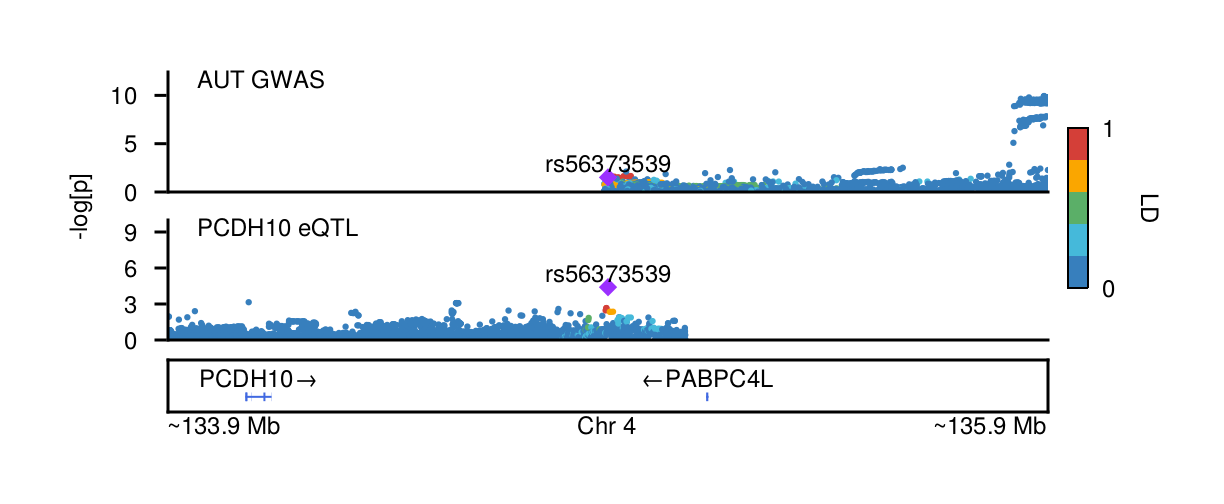

In [34]:
summarystatsdfs = [
    CSV.read("/u/project/gandalm/cindywen/ipsych_gwas/figures/locus25/gwas.txt", DataFrame),
    CSV.read("/u/project/gandalm/cindywen/ipsych_gwas/out/locus25/ENSG00000138650_all_pairs.txt", DataFrame;
                            header = ["geneid", "snpid", "distance", "ma_samples", "ma_count", "maf", "p",
                                      "beta", "slope_se"])
    ]

lddata = [
    read_LDMatrix("/u/project/gandalm/cindywen/ipsych_gwas/data/index_snps_ld_matrices/IndexSNPsRegions_4_134885411_136885411"),
    SnpData("/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/test")
]
summarystatsdfs[2].Z = summarystatsdfs[2].beta ./ summarystatsdfs[2].slope_se

summarystatsdfs[2] = innerjoin(select(lddata[2].snp_info,
                                    :chromosome, :snpid, :position),
                             summarystatsdfs[2]; on = :snpid)

GeneticsMakie.mungesumstats!(summarystatsdfs)
snpid = "rs56373539"

# Finding locus
chr = subset(lddata[end].snp_info,
                    :snpid => col -> col .== snpid)[1, :chromosome]
start = subset(lddata[end].snp_info,
                    :snpid => col -> col .== snpid)[1, :position]
stop = start
range1 = start - 1e6
range2 = stop + 1e6
n = length(summarystatsdfs)
titles = ["AUT GWAS", "PCDH10 eQTL"]
println(subset(lddata[end].snp_info, :snpid => col -> col .== snpid))

# Plotting locuszoom plots
locuszoomcolormap = [colorant"#377fbd",
                     colorant"#45b9da",
                     colorant"#5baf68",
                     colorant"#faa600",
                     colorant"#d43f38"]
CairoMakie.activate!(type = "png", px_per_unit = 4)
f = Figure(resolution = (306, 792))
axs = [Axis(f[i, 1]) for i in 1:(1 + length(summarystatsdfs))]
for i in 1:n
    if typeof(lddata[i]) == SnpData
        ldfilename = tempname()
        SnpArrays.filter(lddata[i].srcbed, lddata[i].srcbim, lddata[i].srcfam,
                         1:size(lddata[i].snparray, 1),
                         findall(row -> row.chromosome == chr &&
                                 range1 <= row.position <= range2,
                                 eachrow(lddata[i].snp_info));
                         des = ldfilename)
        plotlocus!(axs[i], chr, range1, range2, summarystatsdfs[i];
           ld = (SnpData(ldfilename), snpid))
    else
        plotlocus!(axs[i], chr, range1, range2, summarystatsdfs[i];
           ld = (lddata[i], snpid))
    end
    rowsize!(f.layout, i, 30)
    Label(f[i, 1, Top()], titles[i];
          fontsize = 6, halign = :left, padding = (7.5, 0, -5, 0))
end
rs = GeneticsMakie.plotgenes!(axs[n + 1], chr, range1, range2, gencode; height = 0.1)
rowsize!(f.layout, n + 1, rs)
GeneticsMakie.labelgenome(f[n + 1, 1, Bottom()], chr, range1, range2)
Colorbar(f[1:n, 2], limits = (0, 1), ticks = 0:1, height = 40,
         colormap = cgrad(locuszoomcolormap, 5, categorical = true), label = "LD", 
         ticksize = 0, tickwidth = 0, tickalign = 0, ticklabelsize = 6,
         flip_vertical_label = true, labelsize = 6, width = 5, spinewidth = 0.5)
Label(f[1:n, 0], text = "-log[p]", fontsize = 6, rotation = pi / 2)
rowgap!(f.layout, 5)
colgap!(f.layout, 5)
resize_to_layout!(f)
f

In [35]:
CairoMakie.activate!(type = "png")
outputfilename = "/u/project/gandalm/cindywen/ipsych_gwas/figures/locus25/PCDH10.png"
save(outputfilename, f, px_per_unit = 4)

CairoMakie.Screen{IMAGE}


**locus 59(xDx), locus 60 (ADHD), XRN2**

1×6 DataFrame
 Row │ chromosome  snpid       genetic_distance  position  allele1  allele2 
     │ String      String      Float64           Int64     String   String  
─────┼──────────────────────────────────────────────────────────────────────
   1 │ 20          rs28650836               0.0  21420492  T        C


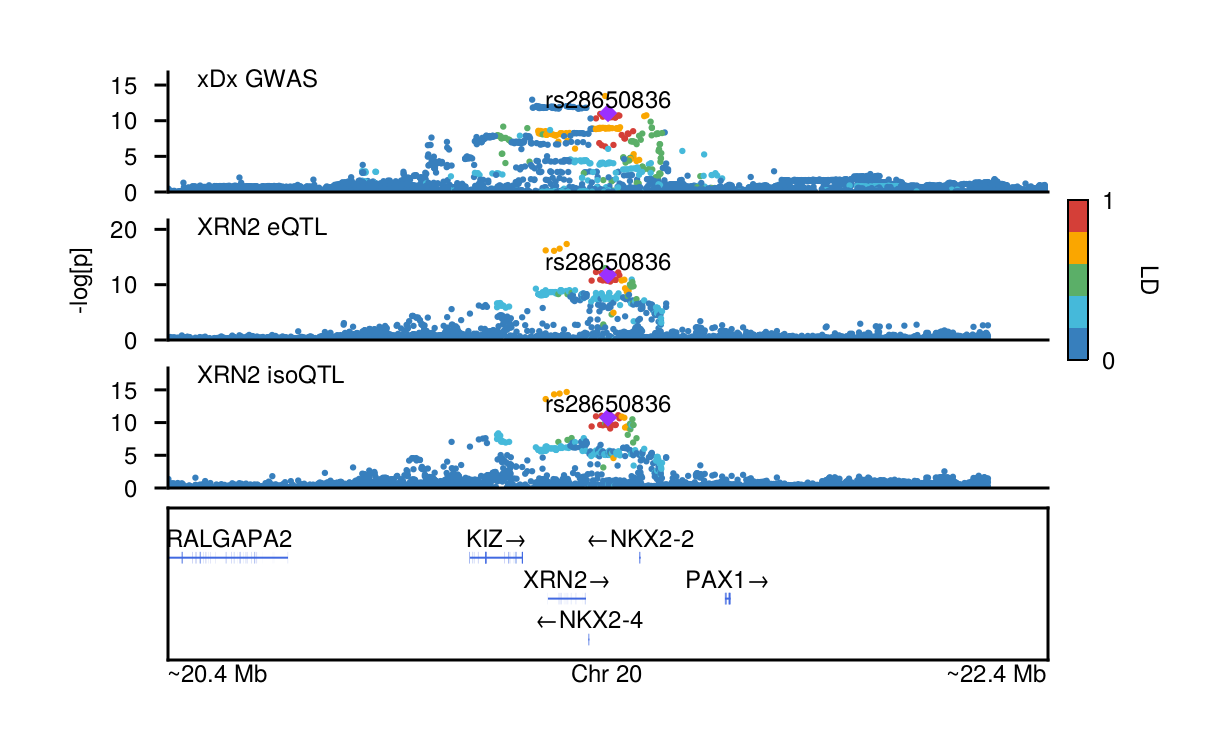

In [44]:
summarystatsdfs = [
    CSV.read("/u/project/gandalm/cindywen/ipsych_gwas/figures/locus59_60/gwas_xdx.txt", DataFrame),
    CSV.read("/u/project/gandalm/cindywen/ipsych_gwas/out/locus59/ENSG00000088930_all_pairs.txt", DataFrame;
                            header = ["geneid", "snpid", "distance", "ma_samples", "ma_count", "maf", "p",
                                      "beta", "slope_se"]),
    CSV.read("/u/project/gandalm/cindywen/ipsych_gwas/out/locus59/ENST00000377191.5_2_all_pairs.txt", DataFrame;
                            header = ["geneid", "snpid", "distance", "ma_samples", "ma_count", "maf", "p",
                                      "beta", "slope_se"])
    ]

lddata = [
    read_LDMatrix("/u/project/gandalm/cindywen/ipsych_gwas/data/index_snps_ld_matrices/IndexSNPsRegions_20_20414037_22414037"),
    SnpData("/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/test"),
    SnpData("/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/test")
]
summarystatsdfs[2].Z = summarystatsdfs[2].beta ./ summarystatsdfs[2].slope_se
summarystatsdfs[3].Z = summarystatsdfs[3].beta ./ summarystatsdfs[3].slope_se

summarystatsdfs[2] = innerjoin(select(lddata[2].snp_info,
                                    :chromosome, :snpid, :position),
                             summarystatsdfs[2]; on = :snpid)
summarystatsdfs[3] = innerjoin(select(lddata[3].snp_info,
                                    :chromosome, :snpid, :position),
                             summarystatsdfs[3]; on = :snpid)

GeneticsMakie.mungesumstats!(summarystatsdfs)
snpid = "rs28650836"

# Finding locus
chr = subset(lddata[end].snp_info,
                    :snpid => col -> col .== snpid)[1, :chromosome]
start = subset(lddata[end].snp_info,
                    :snpid => col -> col .== snpid)[1, :position]
stop = start
range1 = start - 1e6
range2 = stop + 1e6
n = length(summarystatsdfs)
titles = ["xDx GWAS", "XRN2 eQTL", "XRN2 isoQTL"]
println(subset(lddata[end].snp_info, :snpid => col -> col .== snpid))

# Plotting locuszoom plots
locuszoomcolormap = [colorant"#377fbd",
                     colorant"#45b9da",
                     colorant"#5baf68",
                     colorant"#faa600",
                     colorant"#d43f38"]
CairoMakie.activate!(type = "png", px_per_unit = 4)
f = Figure(resolution = (306, 792))
axs = [Axis(f[i, 1]) for i in 1:(1 + length(summarystatsdfs))]
for i in 1:n
    if typeof(lddata[i]) == SnpData
        ldfilename = tempname()
        SnpArrays.filter(lddata[i].srcbed, lddata[i].srcbim, lddata[i].srcfam,
                         1:size(lddata[i].snparray, 1),
                         findall(row -> row.chromosome == chr &&
                                 range1 <= row.position <= range2,
                                 eachrow(lddata[i].snp_info));
                         des = ldfilename)
        plotlocus!(axs[i], chr, range1, range2, summarystatsdfs[i];
           ld = (SnpData(ldfilename), snpid))
    else
        plotlocus!(axs[i], chr, range1, range2, summarystatsdfs[i];
           ld = (lddata[i], snpid))
    end
    rowsize!(f.layout, i, 30)
    Label(f[i, 1, Top()], titles[i];
          fontsize = 6, halign = :left, padding = (7.5, 0, -5, 0))
end
rs = GeneticsMakie.plotgenes!(axs[n + 1], chr, range1, range2, gencode; height = 0.1)
rowsize!(f.layout, n + 1, rs)
GeneticsMakie.labelgenome(f[n + 1, 1, Bottom()], chr, range1, range2)
Colorbar(f[1:n, 2], limits = (0, 1), ticks = 0:1, height = 40,
         colormap = cgrad(locuszoomcolormap, 5, categorical = true), label = "LD", 
         ticksize = 0, tickwidth = 0, tickalign = 0, ticklabelsize = 6,
         flip_vertical_label = true, labelsize = 6, width = 5, spinewidth = 0.5)
Label(f[1:n, 0], text = "-log[p]", fontsize = 6, rotation = pi / 2)
rowgap!(f.layout, 5)
colgap!(f.layout, 5)
resize_to_layout!(f)
f

In [45]:
CairoMakie.activate!(type = "png")
outputfilename = "/u/project/gandalm/cindywen/ipsych_gwas/figures/locus59_60/XRN2_xDx.png"
save(outputfilename, f, px_per_unit = 4)

CairoMakie.Screen{IMAGE}


1×6 DataFrame
 Row │ chromosome  snpid       genetic_distance  position  allele1  allele2 
     │ String      String      Float64           Int64     String   String  
─────┼──────────────────────────────────────────────────────────────────────
   1 │ 20          rs28650836               0.0  21420492  T        C


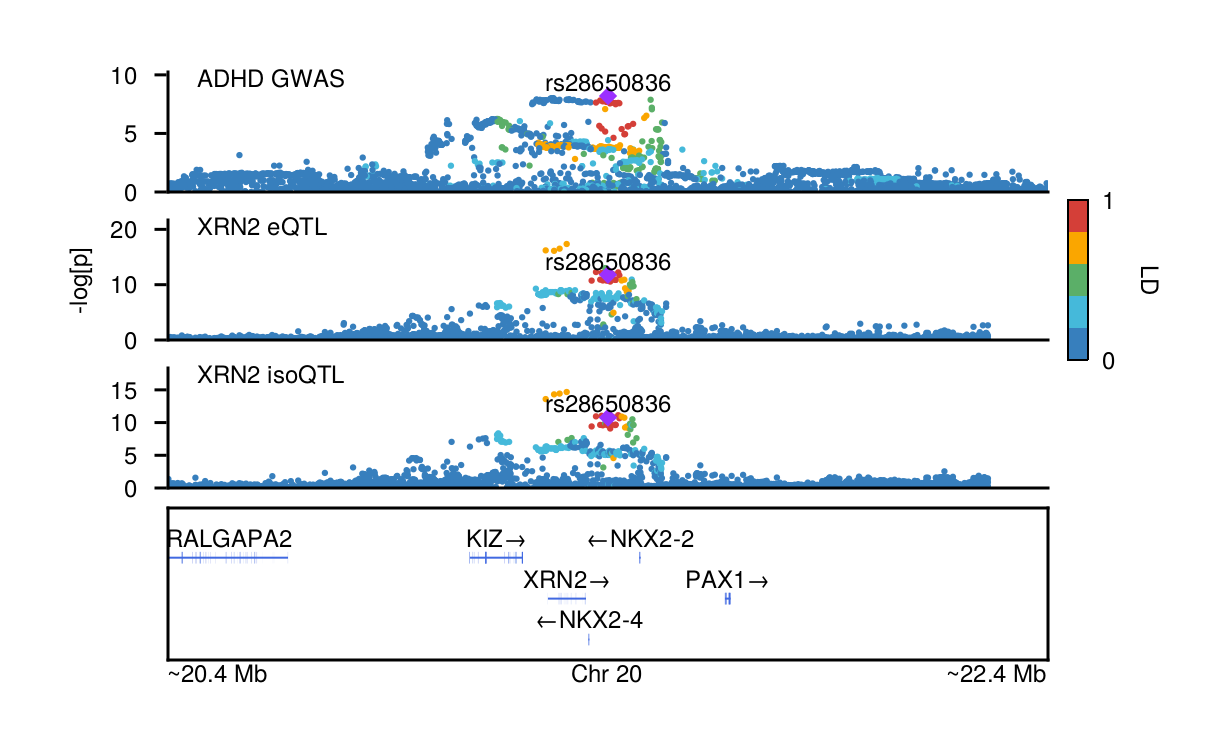

In [46]:
summarystatsdfs = [
    CSV.read("/u/project/gandalm/cindywen/ipsych_gwas/figures/locus59_60/gwas_adhd.txt", DataFrame),
    CSV.read("/u/project/gandalm/cindywen/ipsych_gwas/out/locus60/ENSG00000088930_all_pairs.txt", DataFrame;
                            header = ["geneid", "snpid", "distance", "ma_samples", "ma_count", "maf", "p",
                                      "beta", "slope_se"]),
    CSV.read("/u/project/gandalm/cindywen/ipsych_gwas/out/locus60/ENST00000377191.5_2_all_pairs.txt", DataFrame;
                            header = ["geneid", "snpid", "distance", "ma_samples", "ma_count", "maf", "p",
                                      "beta", "slope_se"])
    ]

lddata = [
    read_LDMatrix("/u/project/gandalm/cindywen/ipsych_gwas/data/index_snps_ld_matrices/IndexSNPsRegions_20_20420492_22420492"),
    SnpData("/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/test"),
    SnpData("/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/test")
]
summarystatsdfs[2].Z = summarystatsdfs[2].beta ./ summarystatsdfs[2].slope_se
summarystatsdfs[3].Z = summarystatsdfs[3].beta ./ summarystatsdfs[3].slope_se

summarystatsdfs[2] = innerjoin(select(lddata[2].snp_info,
                                    :chromosome, :snpid, :position),
                             summarystatsdfs[2]; on = :snpid)
summarystatsdfs[3] = innerjoin(select(lddata[3].snp_info,
                                    :chromosome, :snpid, :position),
                             summarystatsdfs[3]; on = :snpid)

GeneticsMakie.mungesumstats!(summarystatsdfs)
snpid = "rs28650836"

# Finding locus
chr = subset(lddata[end].snp_info,
                    :snpid => col -> col .== snpid)[1, :chromosome]
start = subset(lddata[end].snp_info,
                    :snpid => col -> col .== snpid)[1, :position]
stop = start
range1 = start - 1e6
range2 = stop + 1e6
n = length(summarystatsdfs)
titles = ["ADHD GWAS", "XRN2 eQTL", "XRN2 isoQTL"]
println(subset(lddata[end].snp_info, :snpid => col -> col .== snpid))

# Plotting locuszoom plots
locuszoomcolormap = [colorant"#377fbd",
                     colorant"#45b9da",
                     colorant"#5baf68",
                     colorant"#faa600",
                     colorant"#d43f38"]
CairoMakie.activate!(type = "png", px_per_unit = 4)
f = Figure(resolution = (306, 792))
axs = [Axis(f[i, 1]) for i in 1:(1 + length(summarystatsdfs))]
for i in 1:n
    if typeof(lddata[i]) == SnpData
        ldfilename = tempname()
        SnpArrays.filter(lddata[i].srcbed, lddata[i].srcbim, lddata[i].srcfam,
                         1:size(lddata[i].snparray, 1),
                         findall(row -> row.chromosome == chr &&
                                 range1 <= row.position <= range2,
                                 eachrow(lddata[i].snp_info));
                         des = ldfilename)
        plotlocus!(axs[i], chr, range1, range2, summarystatsdfs[i];
           ld = (SnpData(ldfilename), snpid))
    else
        plotlocus!(axs[i], chr, range1, range2, summarystatsdfs[i];
           ld = (lddata[i], snpid))
    end
    rowsize!(f.layout, i, 30)
    Label(f[i, 1, Top()], titles[i];
          fontsize = 6, halign = :left, padding = (7.5, 0, -5, 0))
end
rs = GeneticsMakie.plotgenes!(axs[n + 1], chr, range1, range2, gencode; height = 0.1)
rowsize!(f.layout, n + 1, rs)
GeneticsMakie.labelgenome(f[n + 1, 1, Bottom()], chr, range1, range2)
Colorbar(f[1:n, 2], limits = (0, 1), ticks = 0:1, height = 40,
         colormap = cgrad(locuszoomcolormap, 5, categorical = true), label = "LD", 
         ticksize = 0, tickwidth = 0, tickalign = 0, ticklabelsize = 6,
         flip_vertical_label = true, labelsize = 6, width = 5, spinewidth = 0.5)
Label(f[1:n, 0], text = "-log[p]", fontsize = 6, rotation = pi / 2)
rowgap!(f.layout, 5)
colgap!(f.layout, 5)
resize_to_layout!(f)
f

In [47]:
CairoMakie.activate!(type = "png")
outputfilename = "/u/project/gandalm/cindywen/ipsych_gwas/figures/locus59_60/XRN2_ADHD.png"
save(outputfilename, f, px_per_unit = 4)

CairoMakie.Screen{IMAGE}


**locus37, PEC isoQTL**

In [5]:
summarystatsdfs = [
    CSV.read("/u/project/gandalm/cindywen/ipsych_gwas/figures/locus37/gwas.txt", DataFrame),
    CSV.read("/u/project/gandalm/cindywen/ipsych_gwas/figures/locus37/ENST00000544436_all_pairs_pec_zscore.txt", DataFrame;
                            header = ["geneid", "snpid", "distance", "p", "beta", "FDR", "Z"])
    ]

# lddata = [
#     read_LDMatrix("/u/project/gandalm/cindywen/ipsych_gwas/data/index_snps_ld_matrices/IndexSNPsRegions_6_162733310_164733310"),
#     SnpData("/u/project/gandalm/shared/GenomicDatasets/PsychENCODE/Genotypes/PsychENCODE_rsid_1321/Capstone4.all_dbSNP_rsid_1321")
# ]

2-element Vector{DataFrame}:
 6850×10 DataFrame
  Row │ SNP          CHR    BP         A1       A2       MAF      BETA     SE  ⋯
      │ String15     Int64  Int64      String1  String1  Float64  Float64  Flo ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │ rs6455889        6  163719877  T        C         0.3261   0.0952   0. ⋯
    2 │ rs59759961       6  163934485  A        G         0.1191   0.11     0.
    3 │ rs73015387       6  163887929  T        C         0.1214   0.1045   0.
    4 │ rs6931903        6  163910325  T        C         0.1212  -0.1041   0.
    5 │ rs742333         6  163719619  T        C         0.4232   0.0691   0. ⋯
    6 │ rs11751619       6  163687633  C        G         0.2316  -0.0752   0.
    7 │ rs11758874       6  163705548  A        G         0.2121  -0.0765   0.
    8 │ rs742332         6  163718566  T        C         0.2179   0.0726   0.
    9 │ rs2179364        6  163719033  C        G         0.2181  -0.0725

From Daniel:
- i think the bim file probably uses 4 spaces instead of tabs or something along those lines, and all the other tools recognizes that all the other spaces should be separators
- the function that we use to read in the plink files is from someone else's package and it seems like it's reading in those spaces wrong

**PEC bim file causing problems. Easiest way would be to re-write the bim file, and use old code**

In [6]:
lddata = [
    read_LDMatrix("/u/project/gandalm/cindywen/ipsych_gwas/data/index_snps_ld_matrices/IndexSNPsRegions_6_162733310_164733310"),
    let
        snpdata = SnpData("/u/project/gandalm/shared/GenomicDatasets/PsychENCODE/Genotypes/PsychENCODE_rsid_1321/Capstone4.all_dbSNP_rsid_1321")
        snp_info = open("/u/project/gandalm/shared/GenomicDatasets/PsychENCODE/Genotypes/PsychENCODE_rsid_1321/Capstone4.all_dbSNP_rsid_1321.bim") do io
            rows = []
            for line in readlines(io)
                linearr = split(line)
                filter(x -> x != "", linearr)
                if length(linearr) != 6
                    throw(linearr)
                end
                push!(rows,
                      (chromosome = string(linearr[1]), snpid = string(linearr[2]),
                       genetic_distance = parse(Float64, linearr[3]), position = parse(Int, linearr[4]),
                       allele1 = string(linearr[5]), allele2 = string(linearr[6])))
            end
            DataFrame(rows)
        end
        finalsnpdata = SnpData(snpdata.people, snpdata.snps, snpdata.snparray, snp_info, snpdata.person_info, 
                               snpdata.srcbed, snpdata.srcbim, snpdata.srcfam)
    end
   ]

2-element Vector{Any}:
 LDMatrix(6830×6 DataFrame
  Row │ chromosome  snpid        genetic_distance  position   allele1  allele2 ⋯
      │ String      String       Float64           Int64      String   String  ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │ 6           rs7762805                 0.0  162733428  G        C       ⋯
    2 │ 6           rs10447369                0.0  162733512  A        C
    3 │ 6           rs7744521                 0.0  162733551  T        A
    4 │ 6           rs7748665                 0.0  162733743  G        A
    5 │ 6           rs7752706                 0.0  162733752  C        T       ⋯
    6 │ 6           rs75547218                0.0  162733832  A        G
    7 │ 6           rs73024766                0.0  162733939  G        A
    8 │ 6           rs7771396                 0.0  162734709  A        G
    9 │ 6           rs12208921                0.0  162735274  G        A       ⋯
   10 │ 6           rs1467

In [11]:
# # remove extra space at the beginning and end of snpid and chr in PEC bfiles
# lddata[2].snp_info[!, 2] = strip.(lddata[2].snp_info[:, 2], ' ')
# lddata[2].snp_info[!, 1] = strip.(lddata[2].snp_info[:, 1], ' ')

In [69]:
# # somehow couldn't inner_join with PEC bim (reason: PEC lddata couldn't be queried, extra space in snpid)
# # added snp info to dataframe (--> this is not neccessary after figuring out the snpid issue)
# summarystatsdfs[2] = CSV.read("/u/project/gandalm/cindywen/ipsych_gwas/figures/locus37/ENST00000544436_all_pairs_pec_zscore_innerjoinbim.txt", DataFrame;
#                             header = ["geneid", "snpid", "chr", "bp", "distance", "p", "beta", "FDR", "Z"])

In [22]:
# somehow QTL snpid is String15; lddata snpinfo snpid is String
# when innerjoin, only chr:pos snpid is left
# convert String15 to String
# convert!(String, summarystatsdfs[2].snpid)
# summarystatsdfs[2].snpid = coalesce.(string.(summarystatsdfs[2].snpid), missing)


In [7]:
summarystatsdfs[2] = innerjoin(select(lddata[2].snp_info,
                                    :chromosome, :snpid, :position),
                             summarystatsdfs[2]; on = :snpid)

Row,chromosome,snpid,position,geneid,distance,p,beta,FDR,Z
,String,String,Int64,String15,Int64,Float64,Float64,Float64,Float64
1,6,rs6938401,162837868,ENST00000544436,-999480,0.237342,-0.0327796,0.845215,-1.18166
2,6,rs6911575,162837874,ENST00000544436,-999474,0.236398,-0.0328466,0.844644,-1.18404
3,6,rs6910346,162837916,ENST00000544436,-999432,0.236153,-0.0328607,0.844501,-1.18466
4,6,rs6933748,162837940,ENST00000544436,-999408,0.235601,-0.0329002,0.844173,-1.18605
5,6,rs6938624,162837996,ENST00000544436,-999352,0.234571,-0.0329771,0.843538,-1.18867
6,6,rs9689396,162838607,ENST00000544436,-998741,0.232137,-0.0331596,0.842047,-1.19487
7,6,rs9295188,162838806,ENST00000544436,-998542,0.232047,-0.0331616,0.841992,-1.1951
8,6,rs9295189,162838828,ENST00000544436,-998520,0.232111,-0.0331571,0.842032,-1.19494
9,6,rs9356014,162839258,ENST00000544436,-998090,0.232547,-0.0331247,0.842295,-1.19382


In [8]:
GeneticsMakie.mungesumstats!(summarystatsdfs)

In [9]:
snpid = "rs742332"

# Finding locus
chr = subset(lddata[end].snp_info,
                    :snpid => col -> col .== snpid)[1, :chromosome]
start = subset(lddata[end].snp_info,
                    :snpid => col -> col .== snpid)[1, :position]
stop = start
range1 = start - 1e6
range2 = stop + 1e6
n = length(summarystatsdfs)
titles = ["SCZ_CC GWAS", "PsychENCODE QKI isoQTL"]
println(subset(lddata[1].snp_info, :snpid => col -> col .== snpid))

1×6 DataFrame
 Row │ chromosome  snpid     genetic_distance  position   allele1  allele2 
     │ String      String    Float64           Int64      String   String  
─────┼─────────────────────────────────────────────────────────────────────
   1 │ 6           rs742332               0.0  163718566  T        C


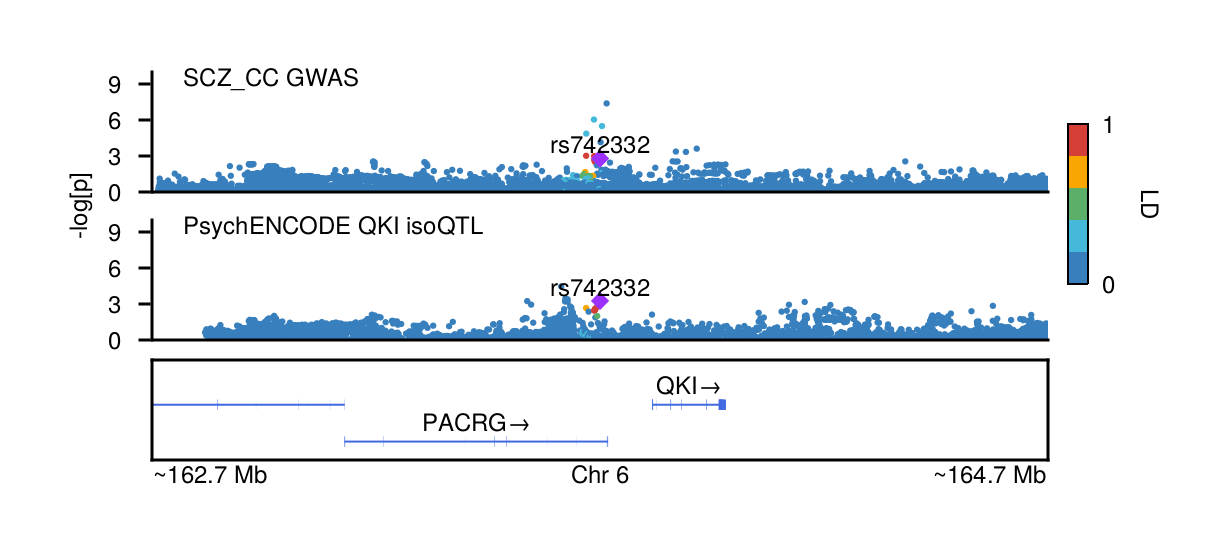

In [10]:
locuszoomcolormap = [colorant"#377fbd",
                     colorant"#45b9da",
                     colorant"#5baf68",
                     colorant"#faa600",
                     colorant"#d43f38"]
CairoMakie.activate!(type = "png", px_per_unit = 4)
f = Figure(resolution = (306, 792))
axs = [Axis(f[i, 1]) for i in 1:(1 + length(summarystatsdfs))]
for i in 1:n
    if typeof(lddata[i]) == SnpData
        ldfilename = tempname()
        SnpArrays.filter(lddata[i].srcbed, lddata[i].srcbim, lddata[i].srcfam,
                         1:size(lddata[i].snparray, 1),
                         findall(row -> row.chromosome == chr &&
                                 range1 <= row.position <= range2,
                                 eachrow(lddata[i].snp_info));
                         des = ldfilename)
        run(`sed -i 's/\s\s*/\t/g' $(ldfilename).bim`) # new line from Daniel, workaround for PEC bim file
        plotlocus!(axs[i], chr, range1, range2, summarystatsdfs[i];
           ld = (SnpData(ldfilename), snpid))
    else
        plotlocus!(axs[i], chr, range1, range2, summarystatsdfs[i];
           ld = (lddata[i], snpid))
    end
    rowsize!(f.layout, i, 30)
    Label(f[i, 1, Top()], titles[i];
          fontsize = 6, halign = :left, padding = (7.5, 0, -5, 0))
end
rs = GeneticsMakie.plotgenes!(axs[n + 1], chr, range1, range2, gencode; height = 0.1)
rowsize!(f.layout, n + 1, rs)
GeneticsMakie.labelgenome(f[n + 1, 1, Bottom()], chr, range1, range2)
Colorbar(f[1:n, 2], limits = (0, 1), ticks = 0:1, height = 40,
         colormap = cgrad(locuszoomcolormap, 5, categorical = true), label = "LD", 
         ticksize = 0, tickwidth = 0, tickalign = 0, ticklabelsize = 6,
         flip_vertical_label = true, labelsize = 6, width = 5, spinewidth = 0.5)
Label(f[1:n, 0], text = "-log[p]", fontsize = 6, rotation = pi / 2)
rowgap!(f.layout, 5)
colgap!(f.layout, 5)
resize_to_layout!(f)
f

In [11]:
CairoMakie.activate!(type = "png")
outputfilename = "/u/project/gandalm/cindywen/ipsych_gwas/figures/locus37/QKI.png"
save(outputfilename, f, px_per_unit = 4)

CairoMakie.Screen{IMAGE}


**locus23, PEC isoQTL COX17**

In [12]:
summarystatsdfs = [
    CSV.read("/u/project/gandalm/cindywen/ipsych_gwas/figures/locus23/gwas.txt", DataFrame),
    CSV.read("/u/project/gandalm/cindywen/ipsych_gwas/figures/locus23/ENST00000497116_all_pairs_pec_zscore.txt", DataFrame;
                            header = ["geneid", "snpid", "distance", "p", "beta", "FDR", "Z"])
    ]

lddata = [
    read_LDMatrix("/u/project/gandalm/cindywen/ipsych_gwas/data/index_snps_ld_matrices/IndexSNPsRegions_3_116831077_118831077"),
    let
        snpdata = SnpData("/u/project/gandalm/shared/GenomicDatasets/PsychENCODE/Genotypes/PsychENCODE_rsid_1321/Capstone4.all_dbSNP_rsid_1321")
        snp_info = open("/u/project/gandalm/shared/GenomicDatasets/PsychENCODE/Genotypes/PsychENCODE_rsid_1321/Capstone4.all_dbSNP_rsid_1321.bim") do io
            rows = []
            for line in readlines(io)
                linearr = split(line)
                filter(x -> x != "", linearr)
                if length(linearr) != 6
                    throw(linearr)
                end
                push!(rows,
                      (chromosome = string(linearr[1]), snpid = string(linearr[2]),
                       genetic_distance = parse(Float64, linearr[3]), position = parse(Int, linearr[4]),
                       allele1 = string(linearr[5]), allele2 = string(linearr[6])))
            end
            DataFrame(rows)
        end
        finalsnpdata = SnpData(snpdata.people, snpdata.snps, snpdata.snparray, snp_info, snpdata.person_info, 
                               snpdata.srcbed, snpdata.srcbim, snpdata.srcfam)
    end
   ]

2-element Vector{Any}:
 LDMatrix(5774×6 DataFrame
  Row │ chromosome  snpid        genetic_distance  position   allele1  allele2 ⋯
      │ String      String       Float64           Int64      String   String  ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │ 3           rs114604611               0.0  116831380  G        A       ⋯
    2 │ 3           rs1474237                 0.0  116831425  T        A
    3 │ 3           rs1474236                 0.0  116831501  C        T
    4 │ 3           rs56390626                0.0  116831930  G        C
    5 │ 3           rs1474114                 0.0  116832030  A        G       ⋯
    6 │ 3           rs9832608                 0.0  116832461  A        G
    7 │ 3           rs59314816                0.0  116833144  C        G
    8 │ 3           rs78502958                0.0  116833181  A        G
    9 │ 3           rs16826109                0.0  116834017  A        T       ⋯
   10 │ 3           rs7809

In [13]:
summarystatsdfs[2] = innerjoin(select(lddata[2].snp_info,
                                    :chromosome, :snpid, :position),
                             summarystatsdfs[2]; on = :snpid)
GeneticsMakie.mungesumstats!(summarystatsdfs)

In [15]:
snpid = "rs10934472"

# Finding locus
chr = subset(lddata[end].snp_info,
                    :snpid => col -> col .== snpid)[1, :chromosome]
start = subset(lddata[end].snp_info,
                    :snpid => col -> col .== snpid)[1, :position]
stop = start
range1 = start - 1e6
range2 = stop + 1e6
n = length(summarystatsdfs)
titles = ["xDx GWAS", "PsychENCODE COX17 isoQTL"]
println(subset(lddata[1].snp_info, :snpid => col -> col .== snpid))

1×6 DataFrame
 Row │ chromosome  snpid       genetic_distance  position   allele1  allele2 
     │ String      String      Float64           Int64      String   String  
─────┼───────────────────────────────────────────────────────────────────────
   1 │ 3           rs10934472               0.0  118735409  C        T


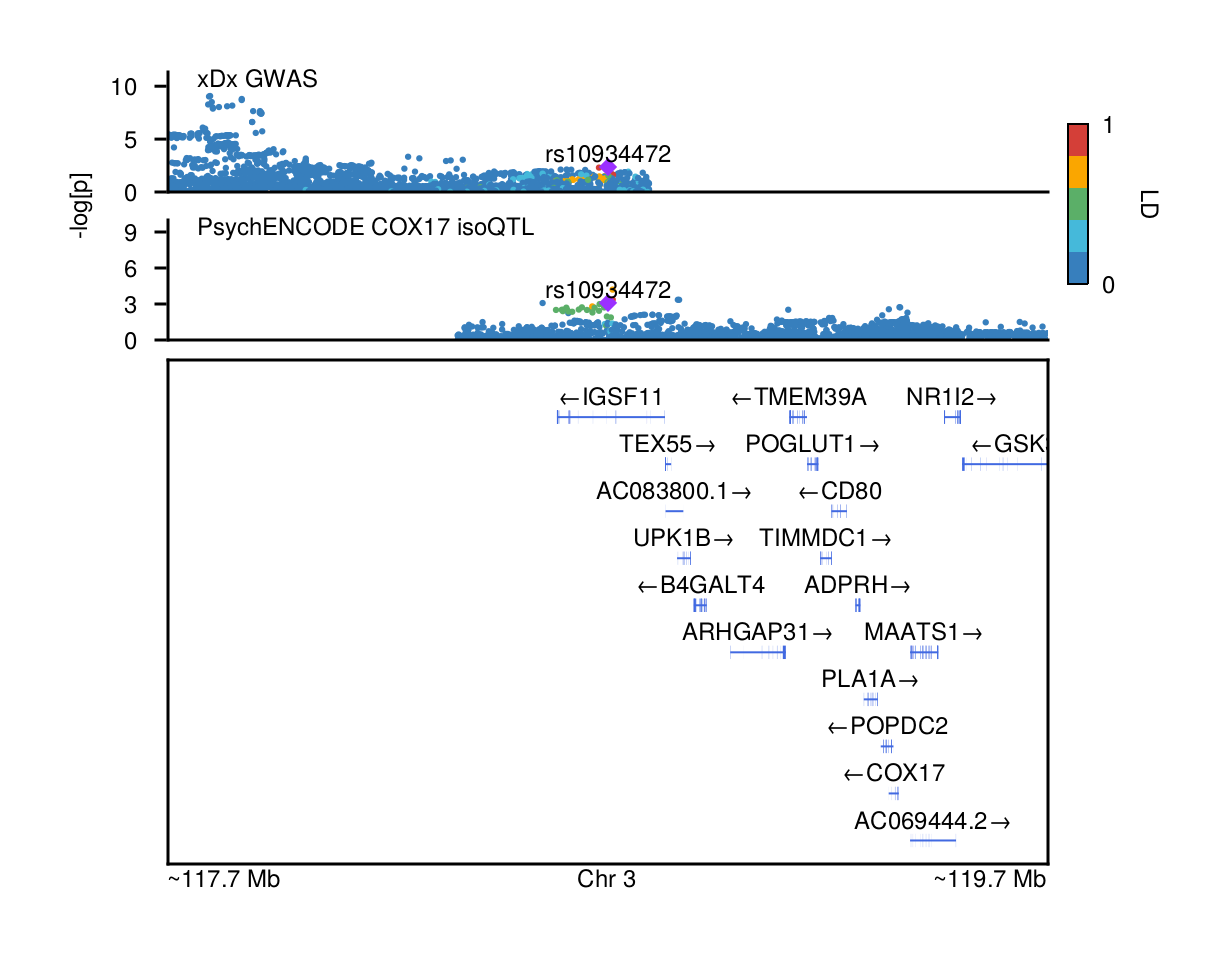

In [16]:
locuszoomcolormap = [colorant"#377fbd",
                     colorant"#45b9da",
                     colorant"#5baf68",
                     colorant"#faa600",
                     colorant"#d43f38"]
CairoMakie.activate!(type = "png", px_per_unit = 4)
f = Figure(resolution = (306, 792))
axs = [Axis(f[i, 1]) for i in 1:(1 + length(summarystatsdfs))]
for i in 1:n
    if typeof(lddata[i]) == SnpData
        ldfilename = tempname()
        SnpArrays.filter(lddata[i].srcbed, lddata[i].srcbim, lddata[i].srcfam,
                         1:size(lddata[i].snparray, 1),
                         findall(row -> row.chromosome == chr &&
                                 range1 <= row.position <= range2,
                                 eachrow(lddata[i].snp_info));
                         des = ldfilename)
        run(`sed -i 's/\s\s*/\t/g' $(ldfilename).bim`) # new line from Daniel, workaround for PEC bim file
        plotlocus!(axs[i], chr, range1, range2, summarystatsdfs[i];
           ld = (SnpData(ldfilename), snpid))
    else
        plotlocus!(axs[i], chr, range1, range2, summarystatsdfs[i];
           ld = (lddata[i], snpid))
    end
    rowsize!(f.layout, i, 30)
    Label(f[i, 1, Top()], titles[i];
          fontsize = 6, halign = :left, padding = (7.5, 0, -5, 0))
end
rs = GeneticsMakie.plotgenes!(axs[n + 1], chr, range1, range2, gencode; height = 0.1)
rowsize!(f.layout, n + 1, rs)
GeneticsMakie.labelgenome(f[n + 1, 1, Bottom()], chr, range1, range2)
Colorbar(f[1:n, 2], limits = (0, 1), ticks = 0:1, height = 40,
         colormap = cgrad(locuszoomcolormap, 5, categorical = true), label = "LD", 
         ticksize = 0, tickwidth = 0, tickalign = 0, ticklabelsize = 6,
         flip_vertical_label = true, labelsize = 6, width = 5, spinewidth = 0.5)
Label(f[1:n, 0], text = "-log[p]", fontsize = 6, rotation = pi / 2)
rowgap!(f.layout, 5)
colgap!(f.layout, 5)
resize_to_layout!(f)
f

In [17]:
CairoMakie.activate!(type = "png")
outputfilename = "/u/project/gandalm/cindywen/ipsych_gwas/figures/locus23/COX17.png"
save(outputfilename, f, px_per_unit = 4)

CairoMakie.Screen{IMAGE}
